In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark
%watermark -v -n -m -p numpy,scipy,sklearn,pandas

Sat Jan 05 2019 

CPython 3.6.6
IPython 6.5.0

numpy 1.15.1
scipy 1.1.0
sklearn 0.19.1
pandas 0.23.4

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.9.0-7-amd64
machine    : x86_64
processor  : 
CPU cores  : 12
interpreter: 64bit


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import nolds
import data
import mne

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
DATA_ROOT = os.path.abspath(os.path.join(PROJ_ROOT, 'data'))
PROCESSED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'processed'))
RAW_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'raw'))
LABELED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'labeled'))
DURATIONS_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'durations'))
print(PROJ_ROOT)
print(DATA_ROOT)
print(PROCESSED_ROOT)
import sys
sys.path.append(os.path.join(PROJ_ROOT, 'src'))
CHANNEL_NAMES = ('FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz')
META_COLUMN_NAMES = ['freq', 'RESP_4W', 'RESP_FIN', 'REMISE_FIN', 'AGE', 'SEX', 'M_1',
       'M_4', 'M_F', 'délka léčby', 'lék 1', 'lék 2', 'lék 3', 'lék 4']
META_FILE_NAME = 'DEP-POOL_Final_144.xlsx'
meta_df = pd.read_excel(os.path.join(RAW_ROOT, META_FILE_NAME), index_col='ID', names=META_COLUMN_NAMES)

raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))
t = pd.DataFrame(raw_fif.get_data())
data = pd.DataFrame(np.transpose(t.values), columns=CHANNEL_NAMES)
data = np.transpose(data.values)
metapkl = pd.read_pickle(os.path.join(LABELED_ROOT, 'processed', 'meta', 'meta.pkl'))

/home/kovar/thesis_project
/home/kovar/thesis_project/data
/home/kovar/thesis_project/data/processed
Opening raw data file /home/kovar/thesis_project/data/processed/1a.fif...
This filename (/home/kovar/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19104 =      0.000 ...    76.416 secs
Ready.


<ipython-input-2-189a96e9ba82>:29: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))


In [28]:
def f(row, col):
    if row[col] <= 8:
        return -1
    if row[col] <= 32:
        return 0
    else:
        return 1
def ff(row, col, n=5):
    for i in range(n):
        if row[col] <= metapkl.quantile((i+1)/n)[col]:
            return i
    
metapkl['dep'] = metapkl.apply(lambda row: f(row, 'sc'), axis=1)
metapkl['dep_bef'] = metapkl.apply(lambda row: f(row, 'sc_bef'), axis=1)
metapkl['dep_aft'] = metapkl.apply(lambda row: f(row, 'sc_aft'), axis=1)
metapkl = metapkl.astype({'dep': 'category', 'dep_bef': 'category', 'dep_aft': 'category'})                                           
print(metapkl['dep'].value_counts())
print(metapkl['dep_bef'].value_counts())
print(metapkl['dep_aft'].value_counts())

def f(row, col):
    if row[col] <= metapkl.quantile(0.15)['change']:
        return -1
    if row[col] <= metapkl.quantile(0.85)['change']:
        return 0
    else:
        return 1
    
metapkl['resp'] = metapkl.apply(lambda row: f(row, 'change'), axis=1)
metapkl = metapkl.astype({'resp': 'category'})                                           
print(metapkl['resp'].value_counts())

 0    225
-1     22
 1     19
Name: dep, dtype: int64
0    234
1     32
Name: dep_bef, dtype: int64
 0    216
-1     44
 1      6
Name: dep_aft, dtype: int64
 0    186
 1     40
-1     40
Name: resp, dtype: int64


In [41]:
def prepare_dfs(col='lyap', kind='processed'): 
    bands = {'delta', 'theta', 'alpha', 'beta', 'gamma'}
    band = None
    if col in bands:
        band = col
        col = 'ampl'
    df = pd.read_pickle(os.path.join(LABELED_ROOT, kind, col, f'training_{col}.pkl')) 
    df_bef = pd.read_pickle(os.path.join(LABELED_ROOT, kind, col, f'{col}_bef.pkl'))
    df_aft = pd.read_pickle(os.path.join(LABELED_ROOT, kind, col, f'{col}_aft.pkl'))
    if band is not None:
        df = df.loc[:, (slice(None), band)]
        df_bef = df_bef.loc[:, (slice(None), band)]
        df_aft = df_aft.loc[:, (slice(None), band)]
    return df, df_bef, df_aft
    
def prepare_resp_non(col='lyap'):
    df, df_bef, df_aft = prepare_dfs(col)
    df = df.drop(metapkl.columns, axis=1, errors='ignore')
    df.columns = df.columns.droplevel(1)
    df = df.join(metapkl)
    return df[df['dep'] == 1], df[df['dep'] == -1]

def prepare_dep_non(col='lyap'):
    df, df_bef, df_aft = prepare_dfs(col)
    df = df.drop(metapkl.columns, axis=1, errors='ignore')
    df.columns = df.columns.droplevel(1)
    df = df.join(metapkl)
    return df[df['dep'] == 1], df[df['dep'] == -1]

col = 'alpha'
df, df_bef, df_aft = prepare_dfs(col)
df_dep, df_nond =  prepare_dep_non(col)
df_resp, df_non = prepare_resp_non(col)
df

channel                FP1          FP2           F3           F4  \
measure              alpha        alpha        alpha        alpha   
patient trial                                                       
1       a       571.861251   662.103762   782.794500   640.377306   
        b       645.759505   691.611589   700.833887   828.837269   
3       a      5924.335478  5683.632607  5920.943765  5295.681431   
        b      4792.456295  4799.077882  4722.770438  4631.115054   
4       a      2707.834309  2832.053489  2159.352697  2524.658315   
        b      2718.251222  2728.426067  2220.125713  1973.311408   
5       a      3348.856191  3251.612691  3126.741666  2543.512794   
        b      2956.432791  2776.224844  2517.449472  1962.342137   
7       a      2177.943393  2277.595393  2058.149831  2314.584047   
        b      2057.212790  2088.860692  2166.001114  2163.199407   
9       a      1677.794568  1710.995638  1703.415693  1826.644709   
        b      2476.682130  2365.615433  2486.176012  2641.417264   
10      a       973.527418  1068.052581   716.871740   831.603673   
        b       462.245945   511.973033   423.009316   490.241836   
11      a      1740.950792  1977.666307  1611.417158  1855.754430   
        b      1615.438024  1776.033342  1492.323266  1804.972950   
12      a      1622.907280  1492.496320  1630.367410  1570.468392   
        b      1217.499891  1253.835500  1295.102552  1386.296203   
14      a      1349.271662  1430.836905  1296.157474  1352.964366   
        b       957.561480   992.231336   863.554930   923.230511   
15      a      1473.879916  1525.227506  1342.894371  1196.638710   
        b      2001.928417  2046.105525  1845.330591  1870.541243   
16      a      2827.314402  2875.940496  2792.970078  2814.608616   
        b      2188.516796  2236.296268  2201.648891  2140.110600   
17      a      1751.941222  1715.888291  1748.406623  1663.445397   
        b      1999.277487  1944.768174  1962.744312  1752.595513   
18      a      1466.737898  1489.261521  1173.070743  1052.770725   
        b      1497.465327  1678.351555  1382.055595  1292.131868   
19      a      2494.176983  2388.703781  2493.361958  2457.847584   
        b      3084.580684  2941.084658  3100.331657  3018.550894   
...                    ...          ...          ...          ...   
115     a      1005.230488  1116.365080   945.700348   967.860612   
        b      1930.329193  1924.464517  1624.777764  1692.149690   
116     a       953.017372   860.319391   922.008910   797.118437   
        b      1285.134238  1293.495191  1220.834294  1155.121453   
117     a      2305.577573  2244.884205  2356.703797  2214.277900   
        b      1953.837522  1945.487287  2149.861573  2034.142226   
119     a      1197.960824  1235.514296  1180.903277  1202.228992   
        b      1324.020503  1116.907322   839.981240   763.811428   
121     a      3037.010656  3004.543112  2844.162400  2919.545128   
        b      3654.274147  3712.103726  3236.216648  3656.013340   
122     a      3183.021574  3374.427522  3063.978658  3301.235301   
        b      3709.794398  3949.703932  3759.821881  3742.470676   
123     a      1514.690637  1434.846725  1226.608656  1054.629462   
        b      2124.387460  2127.028451  1704.727699  1574.100752   
124     a      2025.079532  2073.522077  2025.940198  2082.427386   
        b      1494.543711  1477.443634  1493.828511  1446.804950   
126     a       656.599528   822.896444   629.821520   816.084086   
        b       620.596455   668.877073   613.204790   615.609493   
127     a       953.843473  1008.451870  1051.779185  1078.566352   
        b       983.367023   987.319920  1062.573142   998.649542   
129     a       889.428402   960.735948   701.602547   764.651352   
        b      1497.642036  1497.759660  1412.319012  1344.699176   
130     a      1434.606140  1472.924747  1233.099126  1258.942505   
        b      1123.490536  1258.421067  1070.320025   976.819014  

DFA


/home/kovar/miniconda3/envs/thesis/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

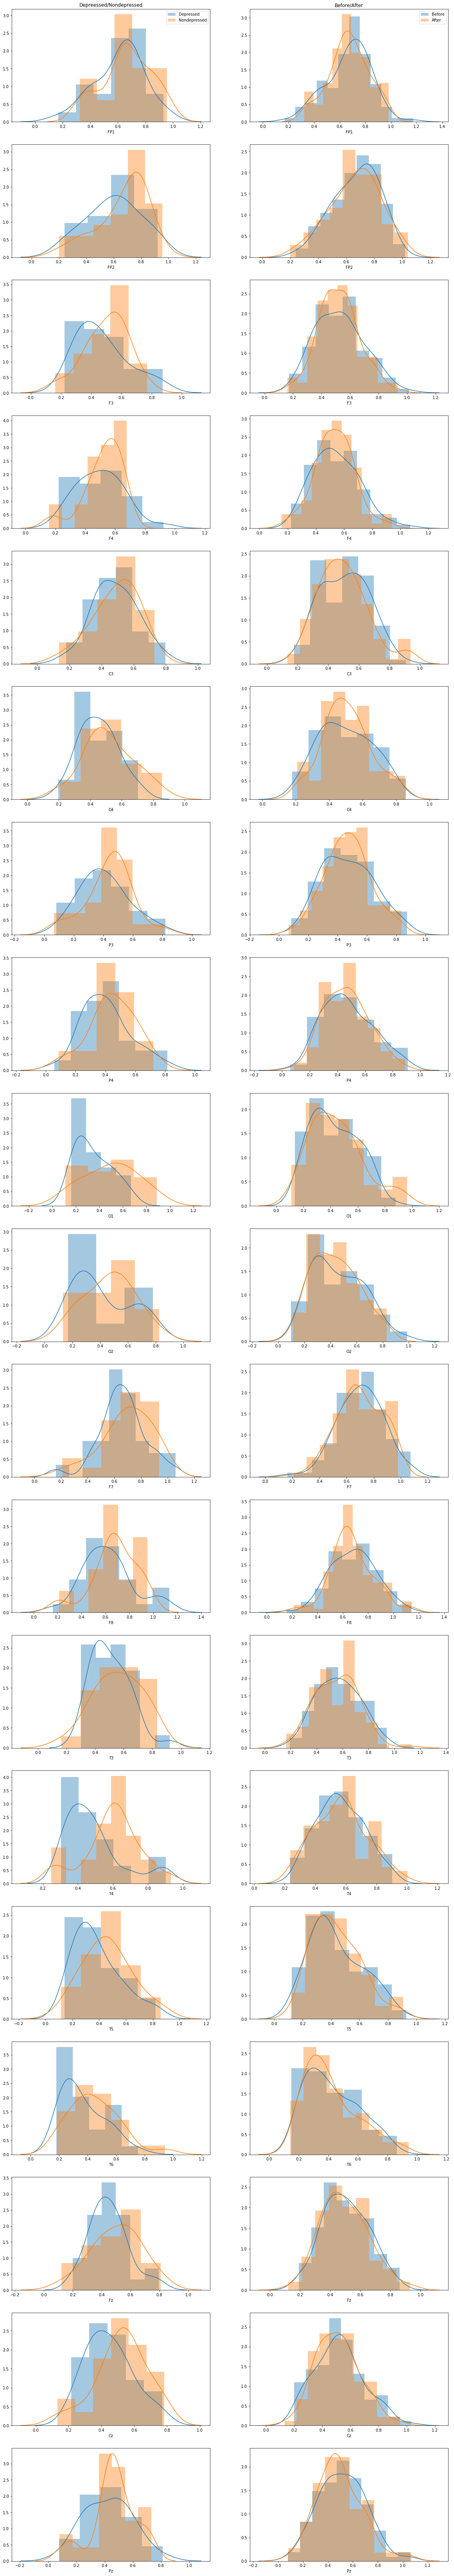

In [40]:
col = 'dfa'
df, df_bef, df_aft = prepare_dfs(col)
df_resp, df_non = prepare_resp_non(col)
df_dep, df_nond = prepare_dep_non(col)
df.columns = df.columns.droplevel(1)
plt.figure()
fig, ax = plt.subplots(19, 2, figsize=(20,120), sharex=False, sharey=False)
print(col.upper())
ax[0, 0].set_title('Depreessed/Nondepressed')
# ax[0, 1].set_title('Responding/Nonresponding')
ax[0, 1].set_title('Before/After')
for i, channel in enumerate(CHANNEL_NAMES):
    sns.distplot(df_dep.loc[:, channel], ax=ax[i, 0], label='Depressed')
    sns.distplot(df_nond.loc[:, channel], ax=ax[i, 0], label='Nondepressed')
    if i == 0:
        ax[0, 0].legend()
# for i, channel in enumerate(CHANNEL_NAMES):
#     sns.distplot(df_resp.loc[:, channel], ax=ax[i, 1], label='Responding')
#     sns.distplot(df_non.loc[:, channel], ax=ax[i, 1], label='Nonresponding')
#     if i == 0:
#         ax[0, 1].legend()
for i, channel in enumerate(CHANNEL_NAMES):
    sns.distplot(df.loc[(slice(None), 'a'), channel], ax=ax[i, 1], label='Before')
    sns.distplot(df.loc[(slice(None), 'b'), channel], ax=ax[i, 1], label='After')
    if i == 0:
        ax[0, 1].legend()
plt.show()

It is not clear that the underlying distributions are normal. This excludes ANOVA as viable test for differing distributions.

THETA


/home/kovar/miniconda3/envs/thesis/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


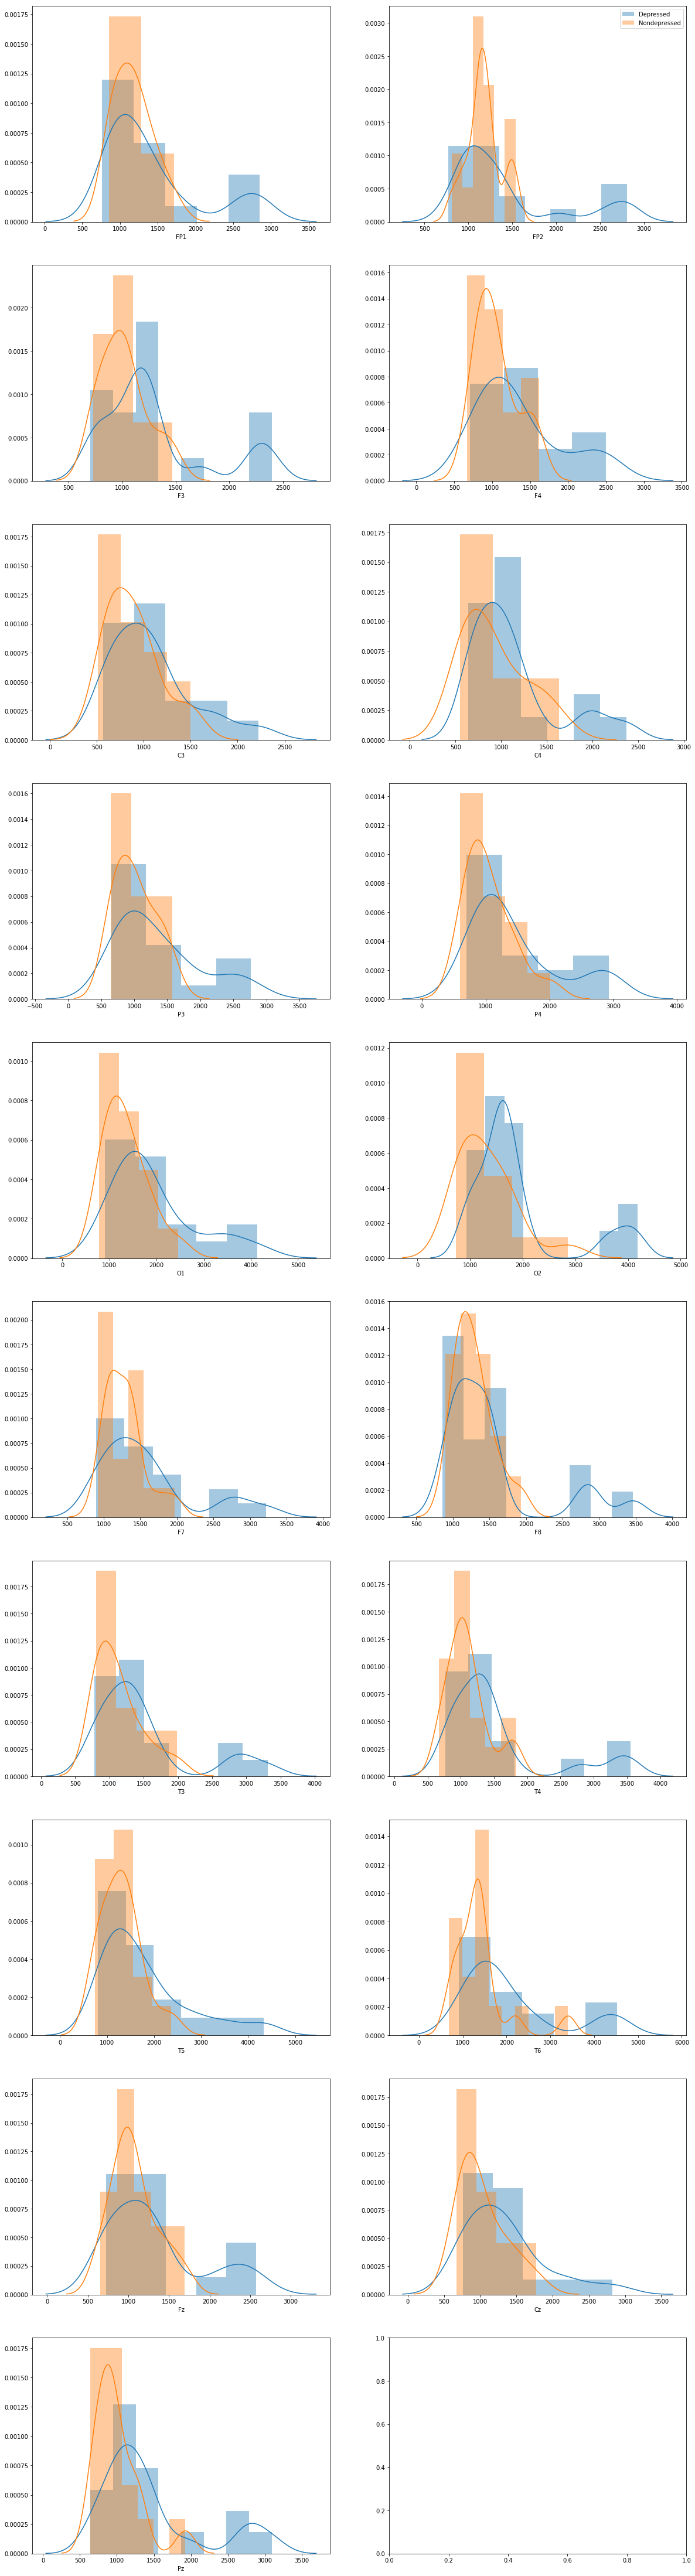

In [43]:
col = 'theta'
df, df_bef, df_aft = prepare_dfs(col)
df_resp, df_non = prepare_resp_non(col)
df_dep, df_nond = prepare_dep_non(col)
print(col.upper())
fig, ax = plt.subplots(10, 2, figsize=(20,80), sharex=False, sharey=False)
for i, channel in enumerate(CHANNEL_NAMES):
    sns.distplot(df_dep.loc[:, channel], ax=ax[i // 2, i%2], label='Depressed')
    sns.distplot(df_nond.loc[:, channel], ax=ax[i // 2, i%2], label='Nondepressed')
ax[0, 1].legend()
plt.show()

/home/kovar/miniconda3/envs/thesis/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


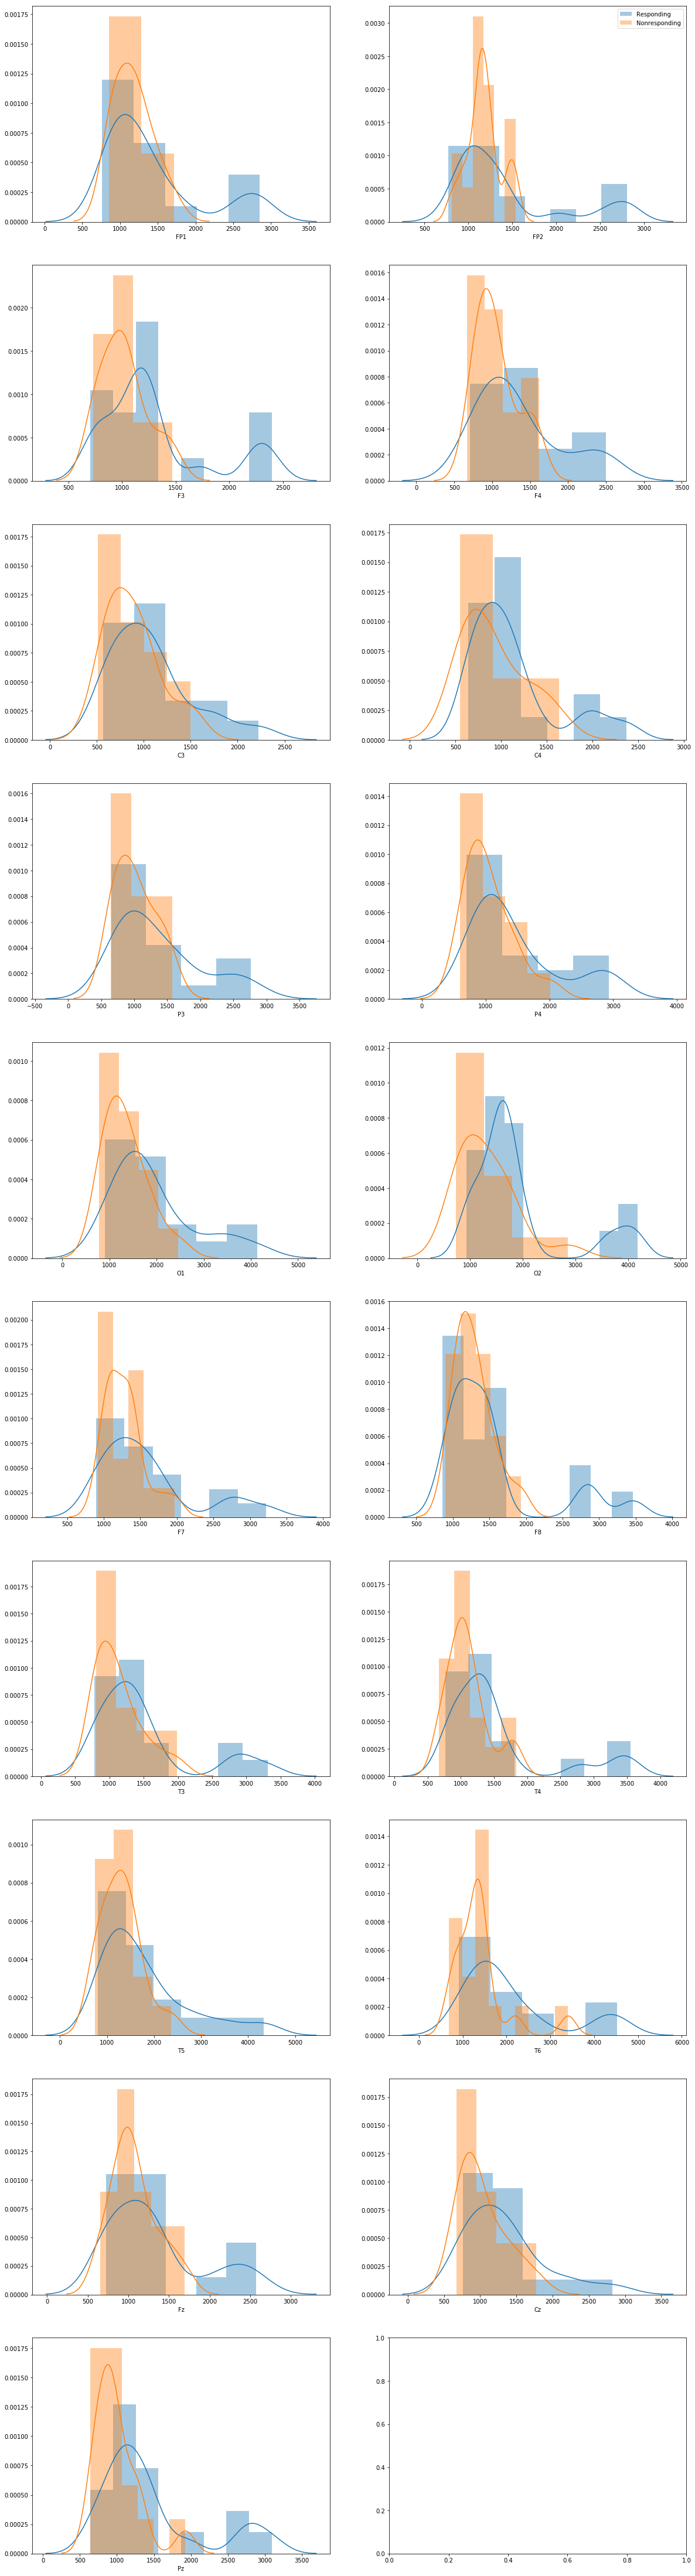

In [44]:
col = 'theta'
df, df_bef, df_aft = prepare_dfs(col)
df_resp, df_non = prepare_resp_non(col)
df_dep, df_nond = prepare_dep_non(col)
fig, ax = plt.subplots(10, 2, figsize=(20,80), sharex=False, sharey=False)
for i, channel in enumerate(CHANNEL_NAMES):
    sns.distplot(df_resp.loc[:, channel], ax=ax[i // 2, i%2], label='Responding')
    sns.distplot(df_non.loc[:, channel], ax=ax[i // 2, i%2], label='Nonresponding')
ax[0, 1].legend()
plt.show()

In [50]:
from scipy.stats import ks_2samp, kruskal, f_oneway

test = f_oneway

def print_res(name, res, mean1=0, mean2=0, std1=0, std2=0):
    if res.pvalue <= 0.01:
        m = '***'
    elif res.pvalue <= 0.02:
        m = '**'
    elif res.pvalue <= 0.05:
        m = '*'
    else:
        m = ''
    print('{: <8} & {: <5.3f} $\pm$ {:<5.3f} & {: <5.3f} $\pm$ {: <5.3f} & {: <5.3f} & {: <5} \\\\ \hline'.format(name, mean1, std1,  mean2, std2,res.pvalue, m))

def channel_wise_ks(df_bef, df_aft):
    dfa = df_bef.loc[:, CHANNEL_NAMES].mean(axis=1)
    dfb = df_aft.loc[:, CHANNEL_NAMES].mean(axis=1)
    print_res('mean', test(dfa, dfb), dfa.mean(), dfb.mean(), dfa.std(), dfb.std())
    dfa = df_bef.loc[:, CHANNEL_NAMES].std(axis=1)
    dfb = df_aft.loc[:, CHANNEL_NAMES].std(axis=1)
    print_res('std', test(dfa, dfb), dfa.mean(), dfb.mean(), dfa.std(), dfb.std())
    for col in CHANNEL_NAMES:
        print_res(col, test(df_bef[col], df_aft[col]), df_bef[col].mean(), df_aft[col].mean(), df_bef[col].std(), df_aft[col].std())
        

# for col in ['lyap', 'corr', 'sampen', 'dfa', 'higu', 'hurst']
for col in ['alpha', 'beta', 'gamma', 'delta', 'theta']:
    df, df_bef, df_aft = prepare_dfs(col)
    df_resp, df_non = prepare_resp_non(col)
    print('\n\n\n' + col.upper())
    # print('\nResponding/Nonresponding all: {} / {}'.format(len(df_resp), len(df_non)))
    # channel_wise_ks(df_resp, df_non)
    # print('\nResponding/Nonresponding before treatment: {} / {}'.format(len(df_resp.loc[(slice(None), 'a'), :]), len(df_non.loc[(slice(None), 'a'), :])))
    # channel_wise_ks(df_resp.loc[(slice(None), 'a'), :] , df_non.loc[(slice(None), 'a'), :])
    # print('\nResponding/Nonresponding after treatment: {} / {}'.format(len(df_resp.loc[(slice(None), 'b'), :]), len(df_non.loc[(slice(None), 'b'), :])))
    # channel_wise_ks(df_resp.loc[(slice(None), 'b'), :] , df_non.loc[(slice(None), 'b'), :])
    # df_dep, df_nond = prepare_dep_non(col)
    print('\nDepressed/Nondepressed all: {} / {}'.format(len(df_dep), len(df_nond)))
    channel_wise_ks(df_dep, df_nond)
    # print('\nDepressed/Nondepressed before: {} / {}'.format(len(df_dep.loc[(slice(None), 'a'), :]), len(df_nond.loc[(slice(None), 'a'), :])))
    # channel_wise_ks(df_dep.loc[(slice(None), 'a'), :], df_nond.loc[(slice(None), 'a'), :])
    # print('\nDepressed/Nondepressed after: {} / {}'.format(len(df_dep.loc[(slice(None), 'b'), :]), len(df_nond.loc[(slice(None), 'b'), :])))
    # channel_wise_ks(df_dep.loc[(slice(None), 'b'), :], df_nond.loc[(slice(None), 'b'), :])




ALPHA

Depressed/Nondepressed all: 18 / 16
mean     & 1507.681 $\pm$ 684.540 & 1133.698 $\pm$ 300.458 & 0.052 &       \\ \hline
std      & 335.662 $\pm$ 169.917 & 226.918 $\pm$ 97.915 & 0.032 & *     \\ \hline
FP1      & 1426.050 $\pm$ 659.642 & 1169.486 $\pm$ 253.872 & 0.154 &       \\ \hline
FP2      & 1432.957 $\pm$ 651.831 & 1179.572 $\pm$ 196.659 & 0.145 &       \\ \hline
F3       & 1307.548 $\pm$ 519.714 & 1018.220 $\pm$ 221.592 & 0.047 & *     \\ \hline
F4       & 1359.306 $\pm$ 563.743 & 1055.226 $\pm$ 281.383 & 0.060 &       \\ \hline
C3       & 1077.045 $\pm$ 442.571 & 882.661 $\pm$ 286.843 & 0.144 &       \\ \hline
C4       & 1132.109 $\pm$ 496.794 & 921.325 $\pm$ 345.385 & 0.166 &       \\ \hline
P3       & 1371.599 $\pm$ 638.614 & 1014.810 $\pm$ 302.729 & 0.050 & *     \\ \hline
P4       & 1468.719 $\pm$ 713.433 & 1048.957 $\pm$ 377.856 & 0.043 & *     \\ \hline
O1       & 1941.154 $\pm$ 904.951 & 1338.946 $\pm$ 456.808 & 0.022 & *     \\ \hline
O2       & 1909.631 $\pm

# Depression score correlations
There is a correlation between lyap10_3_50.pkl and depression score between the most depressed (>=32) and least depressed (<= 8). The same for dfa_4_300_11.pkl

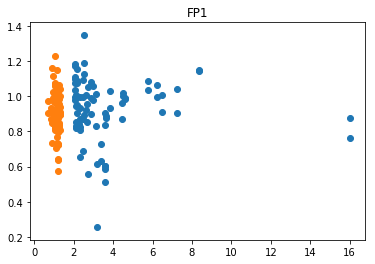

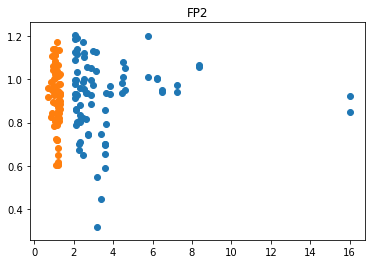

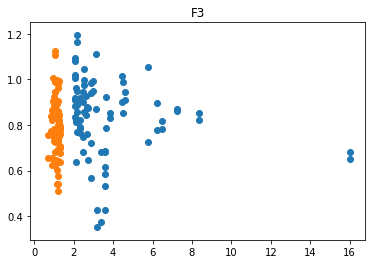

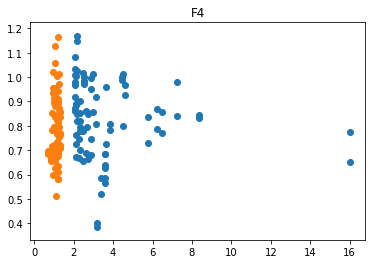

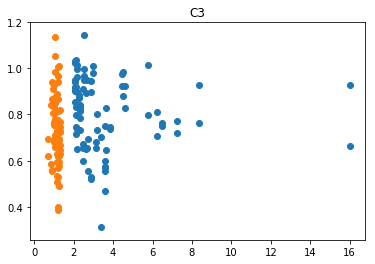

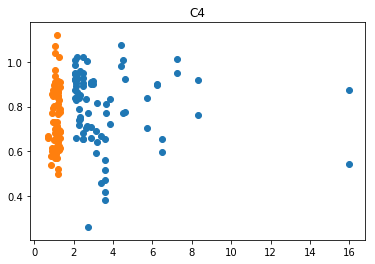

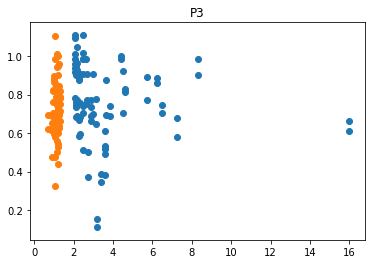

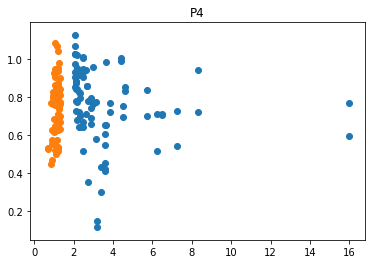

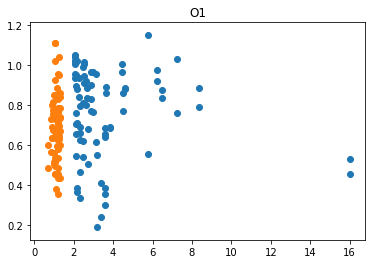

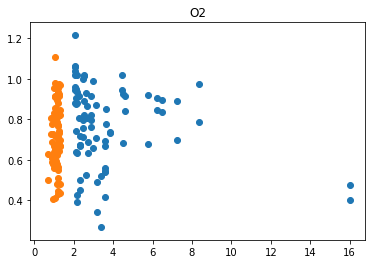

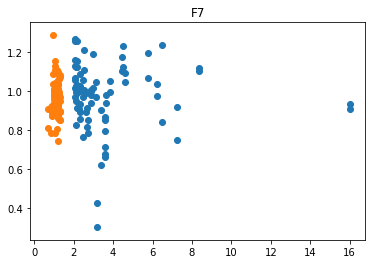

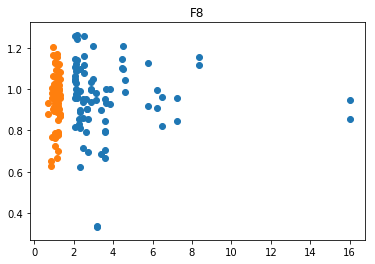

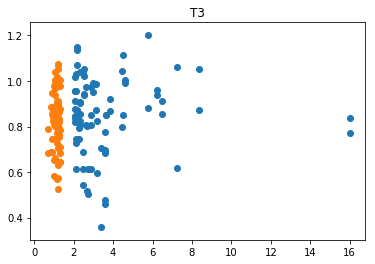

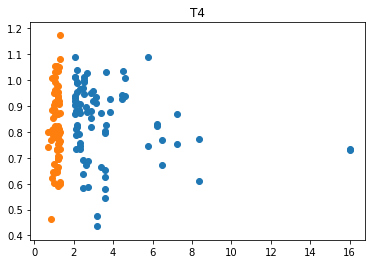

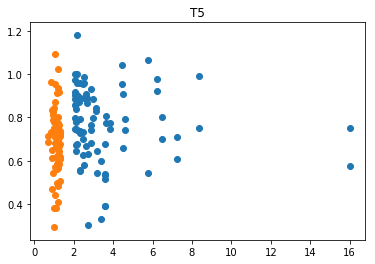

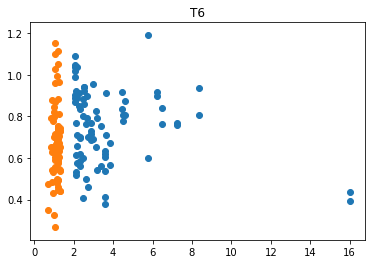

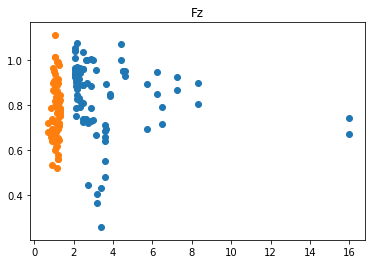

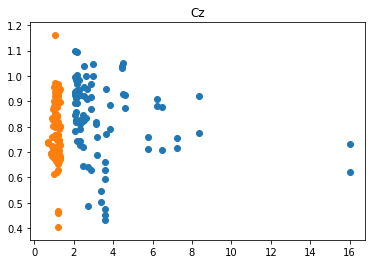

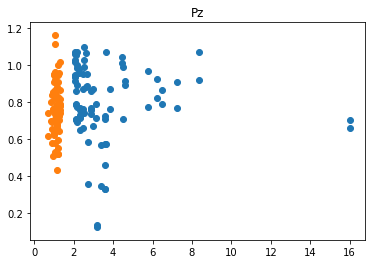

In [27]:
col = 'dfa'
df, df_bef, df_aft = prepare_dfs(col)
df_dep, df_nond = prepare_dep_non(col)
df_resp, df_non = prepare_resp_non(col)
# df_dep.columns = df_dep.columns.droplevel(1)
# df_nond.columns = df_nond.columns.droplevel(1)
# wmd = df_dep.join(metapkl)
# wmn = df_nond.join(metapkl)
rows = (slice(None), slice(None))
for channel in CHANNEL_NAMES:
    plt.figure(1)
    plt.title(channel)
    # plt.scatter(df_dep.loc[rows, 'sc'], df_dep.loc[rows, channel])
    # plt.scatter(df_nond.loc[rows, 'sc'], df_nond.loc[rows, channel])
    plt.scatter(df_resp.loc[rows, 'change'], df_resp.loc[rows, channel])
    plt.scatter(df_non.loc[rows, 'change'], df_non.loc[rows, channel])
    plt.show()

# Average FFT amplitudes for bands

/home/kovar/thesis_project/
Opening raw data file /home/kovar/thesis_project/data/processed/44a.fif...
This filename (/home/kovar/thesis_project/data/processed/44a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15000 =      0.000 ...    60.000 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/44a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


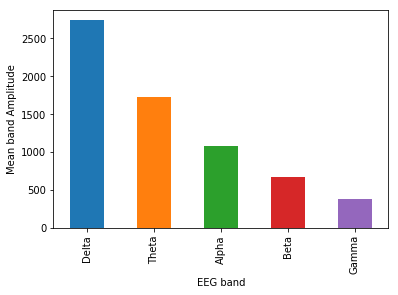

Opening raw data file /home/kovar/thesis_project/data/processed/86a.fif...
This filename (/home/kovar/thesis_project/data/processed/86a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 17938 =      0.000 ...    71.752 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/86a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


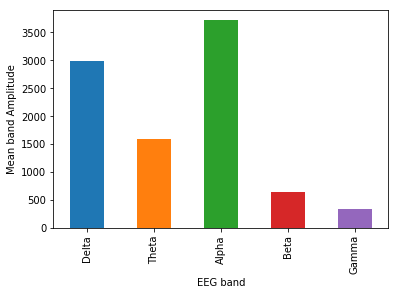

Opening raw data file /home/kovar/thesis_project/data/processed/26b.fif...
This filename (/home/kovar/thesis_project/data/processed/26b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19603 =      0.000 ...    78.412 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/26b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


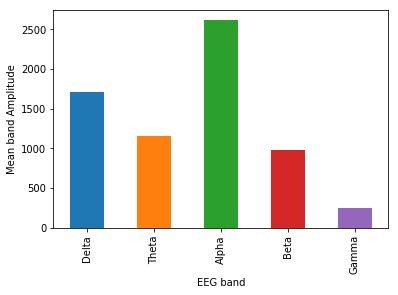

Opening raw data file /home/kovar/thesis_project/data/processed/27b.fif...
This filename (/home/kovar/thesis_project/data/processed/27b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15000 =      0.000 ...    60.000 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/27b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


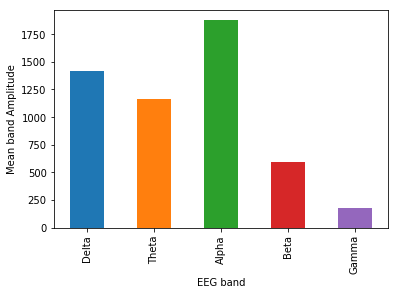

Opening raw data file /home/kovar/thesis_project/data/processed/22b.fif...
This filename (/home/kovar/thesis_project/data/processed/22b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19124 =      0.000 ...    76.496 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/22b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


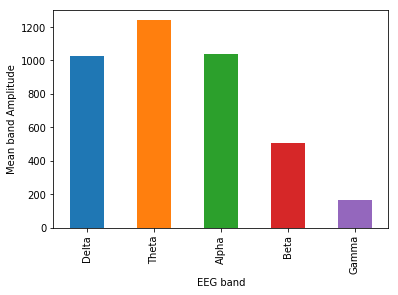

Opening raw data file /home/kovar/thesis_project/data/processed/50b.fif...
This filename (/home/kovar/thesis_project/data/processed/50b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 17508 =      0.000 ...    70.032 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/50b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


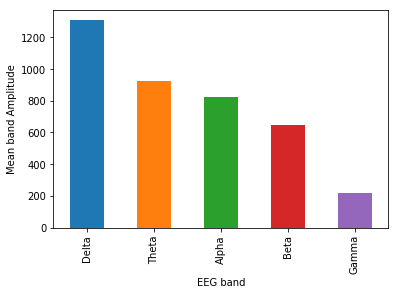

Opening raw data file /home/kovar/thesis_project/data/processed/17b.fif...
This filename (/home/kovar/thesis_project/data/processed/17b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15183 =      0.000 ...    60.732 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/17b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


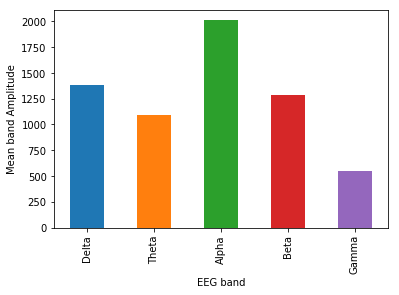

Opening raw data file /home/kovar/thesis_project/data/processed/14a.fif...
This filename (/home/kovar/thesis_project/data/processed/14a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 20582 =      0.000 ...    82.328 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/14a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


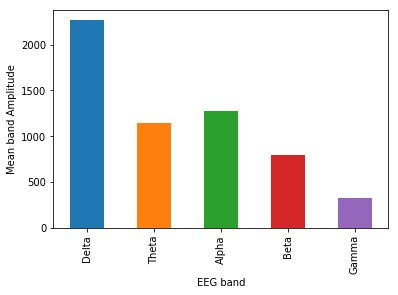

Opening raw data file /home/kovar/thesis_project/data/processed/34b.fif...
This filename (/home/kovar/thesis_project/data/processed/34b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 20724 =      0.000 ...    82.896 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/34b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


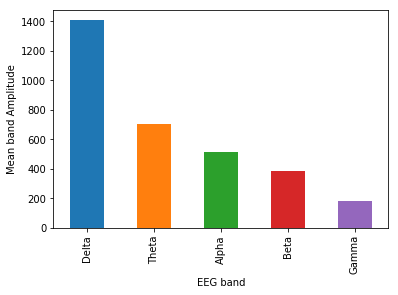

Opening raw data file /home/kovar/thesis_project/data/processed/107a.fif...
This filename (/home/kovar/thesis_project/data/processed/107a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 20798 =      0.000 ...    83.192 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/107a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


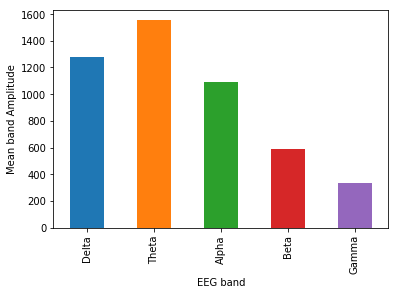

Opening raw data file /home/kovar/thesis_project/data/processed/96b.fif...
This filename (/home/kovar/thesis_project/data/processed/96b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15000 =      0.000 ...    60.000 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/96b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


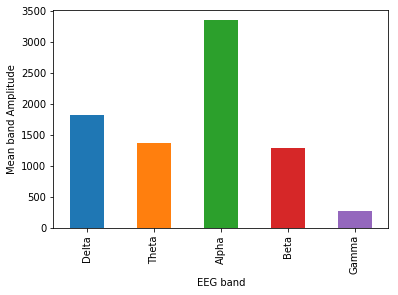

Opening raw data file /home/kovar/thesis_project/data/processed/9a.fif...
This filename (/home/kovar/thesis_project/data/processed/9a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16373 =      0.000 ...    65.492 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/9a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


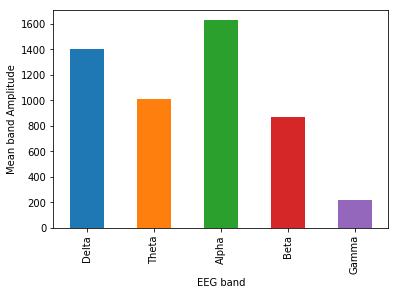

Opening raw data file /home/kovar/thesis_project/data/processed/6b.fif...
This filename (/home/kovar/thesis_project/data/processed/6b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 17193 =      0.000 ...    68.772 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/6b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


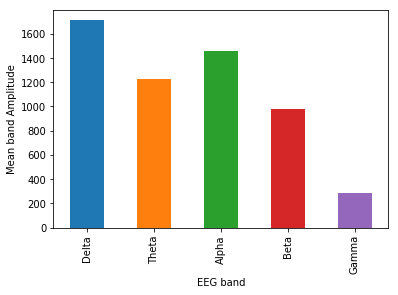

Opening raw data file /home/kovar/thesis_project/data/processed/126a.fif...
This filename (/home/kovar/thesis_project/data/processed/126a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15508 =      0.000 ...    62.032 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/126a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


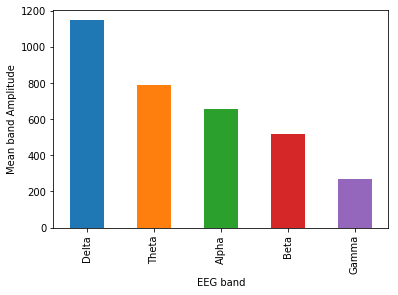

Opening raw data file /home/kovar/thesis_project/data/processed/80b.fif...
This filename (/home/kovar/thesis_project/data/processed/80b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15491 =      0.000 ...    61.964 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/80b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


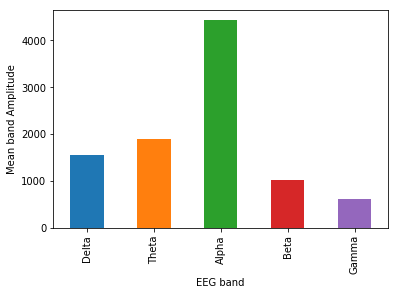

Opening raw data file /home/kovar/thesis_project/data/processed/110b.fif...
This filename (/home/kovar/thesis_project/data/processed/110b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 24394 =      0.000 ...    97.576 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/110b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


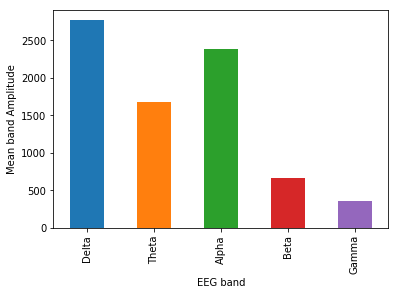

Opening raw data file /home/kovar/thesis_project/data/processed/61b.fif...
This filename (/home/kovar/thesis_project/data/processed/61b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 24442 =      0.000 ...    97.768 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/61b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


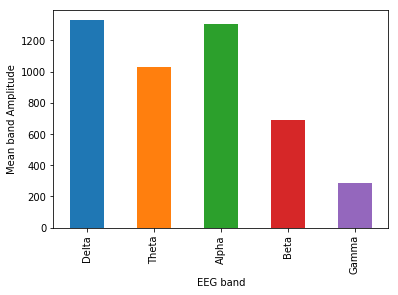

Opening raw data file /home/kovar/thesis_project/data/processed/131a.fif...
This filename (/home/kovar/thesis_project/data/processed/131a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19056 =      0.000 ...    76.224 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/131a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


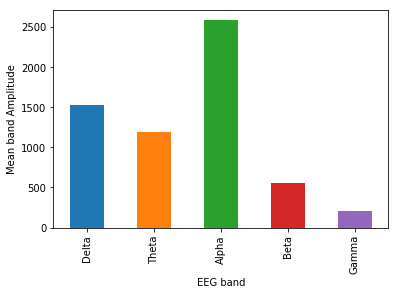

Opening raw data file /home/kovar/thesis_project/data/processed/91a.fif...
This filename (/home/kovar/thesis_project/data/processed/91a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15235 =      0.000 ...    60.940 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/91a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


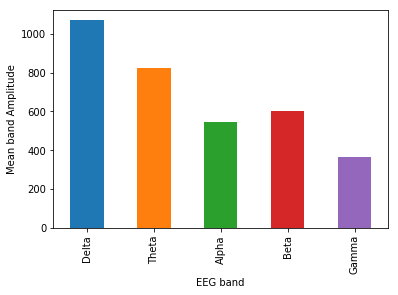

Opening raw data file /home/kovar/thesis_project/data/processed/85b.fif...
This filename (/home/kovar/thesis_project/data/processed/85b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16134 =      0.000 ...    64.536 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/85b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


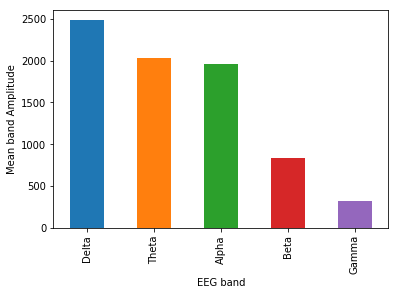

Opening raw data file /home/kovar/thesis_project/data/processed/5b.fif...
This filename (/home/kovar/thesis_project/data/processed/5b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 20698 =      0.000 ...    82.792 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/5b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


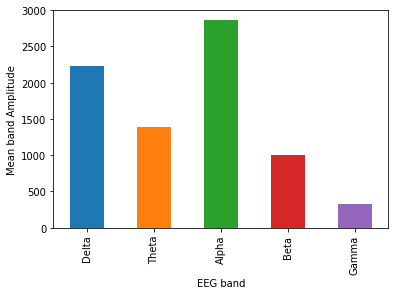

Opening raw data file /home/kovar/thesis_project/data/processed/11a.fif...
This filename (/home/kovar/thesis_project/data/processed/11a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 18345 =      0.000 ...    73.380 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/11a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


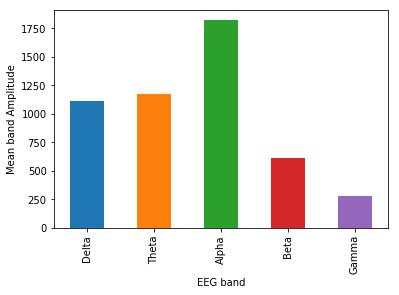

Opening raw data file /home/kovar/thesis_project/data/processed/61a.fif...
This filename (/home/kovar/thesis_project/data/processed/61a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19380 =      0.000 ...    77.520 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/61a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


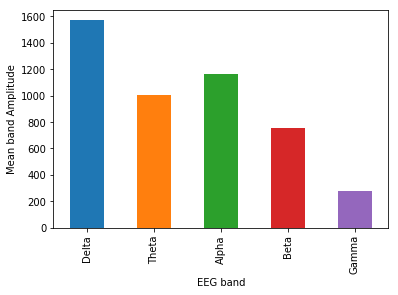

Opening raw data file /home/kovar/thesis_project/data/processed/94b.fif...
This filename (/home/kovar/thesis_project/data/processed/94b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19187 =      0.000 ...    76.748 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/94b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


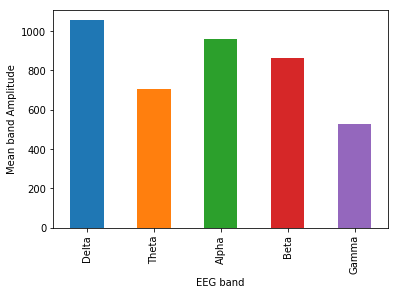

Opening raw data file /home/kovar/thesis_project/data/processed/79b.fif...
This filename (/home/kovar/thesis_project/data/processed/79b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 28767 =      0.000 ...   115.068 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/79b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


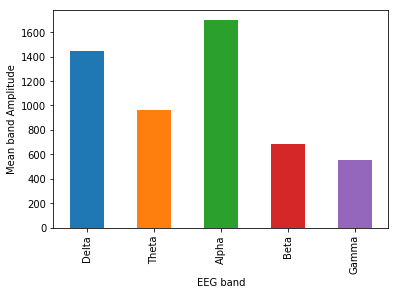

Opening raw data file /home/kovar/thesis_project/data/processed/38b.fif...
This filename (/home/kovar/thesis_project/data/processed/38b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19004 =      0.000 ...    76.016 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/38b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


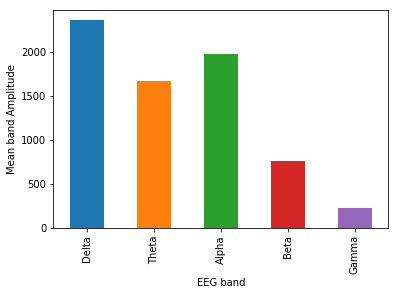

Opening raw data file /home/kovar/thesis_project/data/processed/73b.fif...
This filename (/home/kovar/thesis_project/data/processed/73b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 27294 =      0.000 ...   109.176 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/73b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


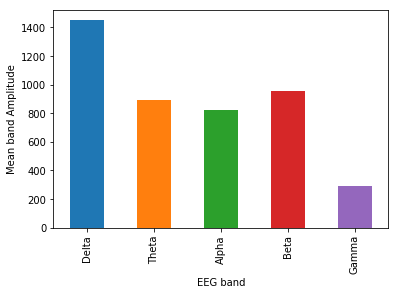

Opening raw data file /home/kovar/thesis_project/data/processed/51a.fif...
This filename (/home/kovar/thesis_project/data/processed/51a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15000 =      0.000 ...    60.000 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/51a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


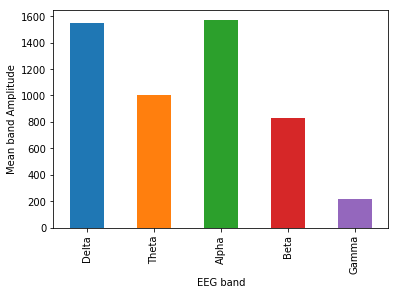

Opening raw data file /home/kovar/thesis_project/data/processed/96a.fif...
This filename (/home/kovar/thesis_project/data/processed/96a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 20144 =      0.000 ...    80.576 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/96a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


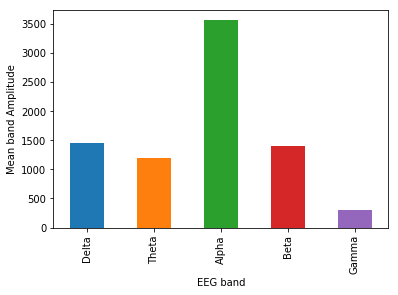

Opening raw data file /home/kovar/thesis_project/data/processed/35a.fif...
This filename (/home/kovar/thesis_project/data/processed/35a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15000 =      0.000 ...    60.000 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/35a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


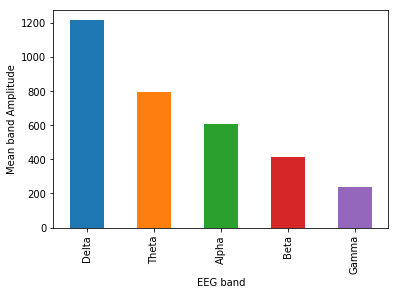

Opening raw data file /home/kovar/thesis_project/data/processed/78a.fif...
This filename (/home/kovar/thesis_project/data/processed/78a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15350 =      0.000 ...    61.400 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/78a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


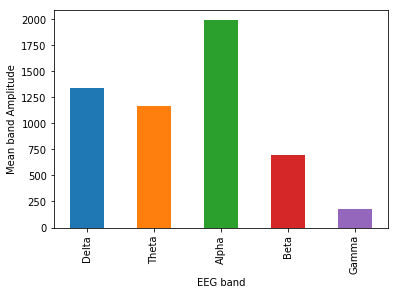

Opening raw data file /home/kovar/thesis_project/data/processed/95a.fif...
This filename (/home/kovar/thesis_project/data/processed/95a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16262 =      0.000 ...    65.048 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/95a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


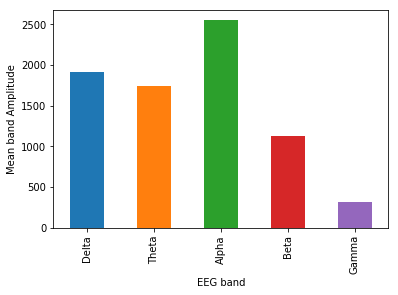

Opening raw data file /home/kovar/thesis_project/data/processed/85a.fif...
This filename (/home/kovar/thesis_project/data/processed/85a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 5887 =      0.000 ...    23.548 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/85a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


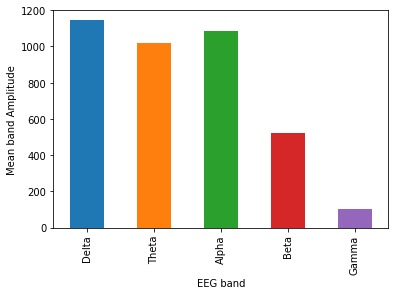

Opening raw data file /home/kovar/thesis_project/data/processed/7b.fif...
This filename (/home/kovar/thesis_project/data/processed/7b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15162 =      0.000 ...    60.648 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/7b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


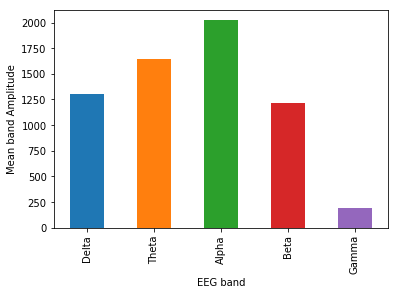

Opening raw data file /home/kovar/thesis_project/data/processed/53b.fif...
This filename (/home/kovar/thesis_project/data/processed/53b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15008 =      0.000 ...    60.032 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/53b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


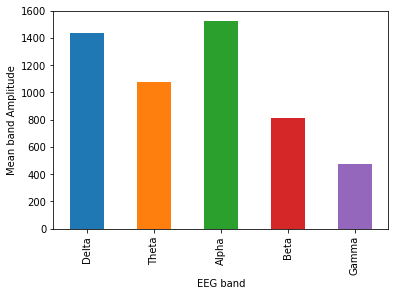

Opening raw data file /home/kovar/thesis_project/data/processed/25b.fif...
This filename (/home/kovar/thesis_project/data/processed/25b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19351 =      0.000 ...    77.404 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/25b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


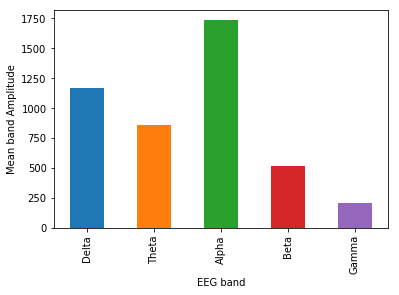

Opening raw data file /home/kovar/thesis_project/data/processed/80a.fif...
This filename (/home/kovar/thesis_project/data/processed/80a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 20313 =      0.000 ...    81.252 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/80a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


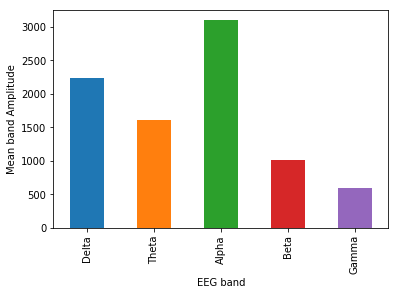

Opening raw data file /home/kovar/thesis_project/data/processed/112b.fif...
This filename (/home/kovar/thesis_project/data/processed/112b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 20195 =      0.000 ...    80.780 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/112b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


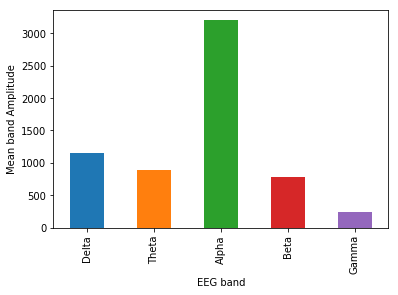

Opening raw data file /home/kovar/thesis_project/data/processed/122b.fif...
This filename (/home/kovar/thesis_project/data/processed/122b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 18156 =      0.000 ...    72.624 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/122b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


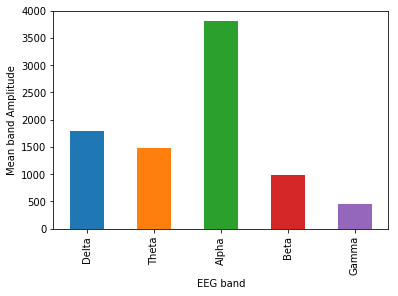

Opening raw data file /home/kovar/thesis_project/data/processed/49a.fif...
This filename (/home/kovar/thesis_project/data/processed/49a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 21860 =      0.000 ...    87.440 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/49a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


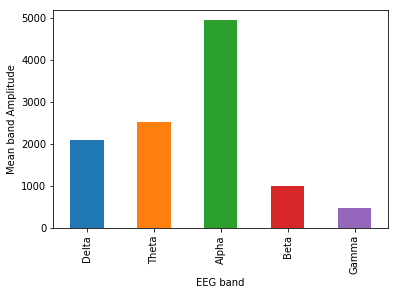

Opening raw data file /home/kovar/thesis_project/data/processed/90b.fif...
This filename (/home/kovar/thesis_project/data/processed/90b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 10098 =      0.000 ...    40.392 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/90b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


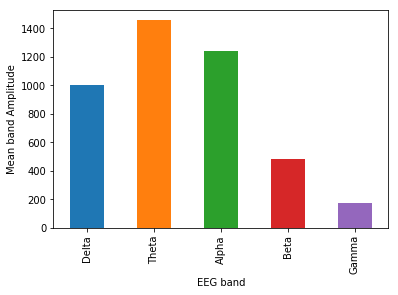

Opening raw data file /home/kovar/thesis_project/data/processed/12a.fif...
This filename (/home/kovar/thesis_project/data/processed/12a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15000 =      0.000 ...    60.000 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/12a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


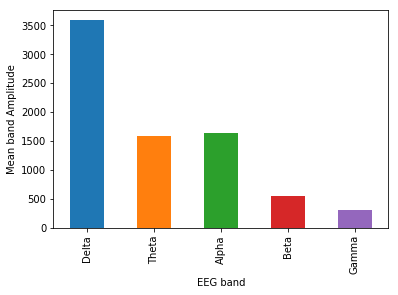

Opening raw data file /home/kovar/thesis_project/data/processed/11b.fif...
This filename (/home/kovar/thesis_project/data/processed/11b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 21319 =      0.000 ...    85.276 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/11b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


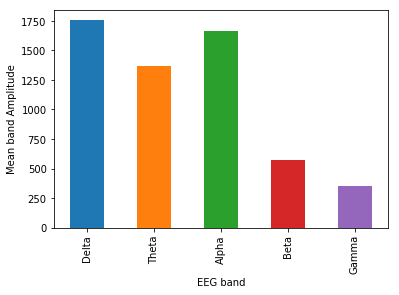

Opening raw data file /home/kovar/thesis_project/data/processed/21a.fif...
This filename (/home/kovar/thesis_project/data/processed/21a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 7743 =      0.000 ...    30.972 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/21a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


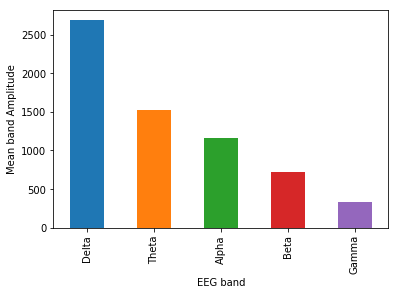

Opening raw data file /home/kovar/thesis_project/data/processed/71b.fif...
This filename (/home/kovar/thesis_project/data/processed/71b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 25438 =      0.000 ...   101.752 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/71b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


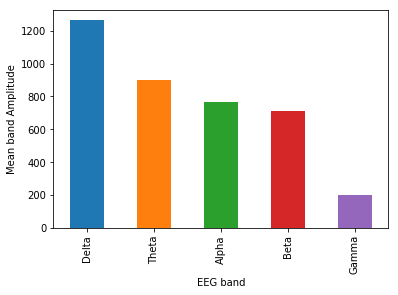

Opening raw data file /home/kovar/thesis_project/data/processed/18b.fif...
This filename (/home/kovar/thesis_project/data/processed/18b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16754 =      0.000 ...    67.016 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/18b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


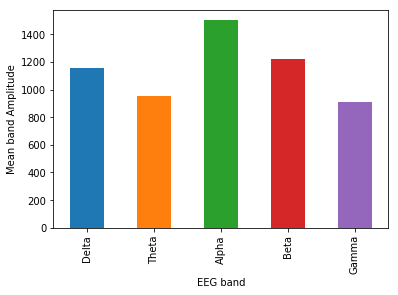

Opening raw data file /home/kovar/thesis_project/data/processed/10b.fif...
This filename (/home/kovar/thesis_project/data/processed/10b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 18777 =      0.000 ...    75.108 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/10b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


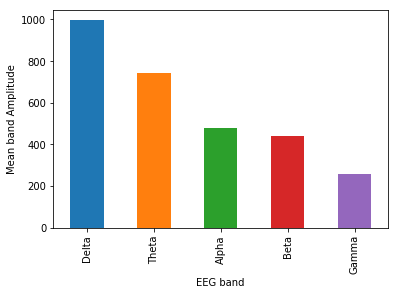

Opening raw data file /home/kovar/thesis_project/data/processed/118a.fif...
This filename (/home/kovar/thesis_project/data/processed/118a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 18484 =      0.000 ...    73.936 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/118a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


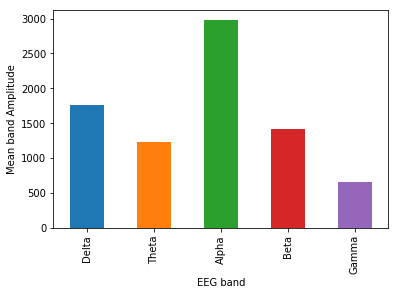

Opening raw data file /home/kovar/thesis_project/data/processed/4a.fif...
This filename (/home/kovar/thesis_project/data/processed/4a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15327 =      0.000 ...    61.308 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/4a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


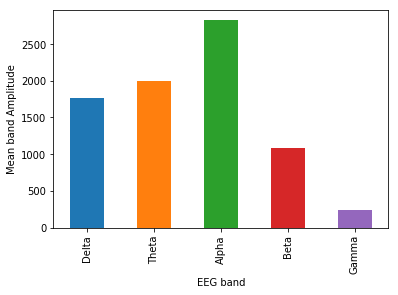

Opening raw data file /home/kovar/thesis_project/data/processed/113a.fif...
This filename (/home/kovar/thesis_project/data/processed/113a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15000 =      0.000 ...    60.000 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/113a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


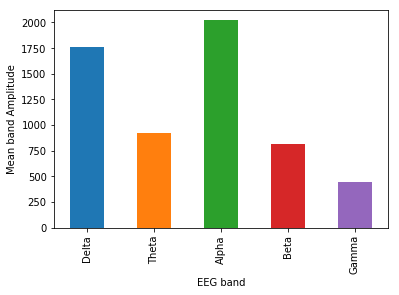

Opening raw data file /home/kovar/thesis_project/data/processed/15a.fif...
This filename (/home/kovar/thesis_project/data/processed/15a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 21716 =      0.000 ...    86.864 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/15a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


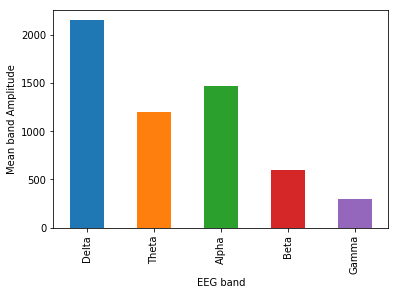

Opening raw data file /home/kovar/thesis_project/data/processed/60a.fif...
This filename (/home/kovar/thesis_project/data/processed/60a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 17034 =      0.000 ...    68.136 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/60a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


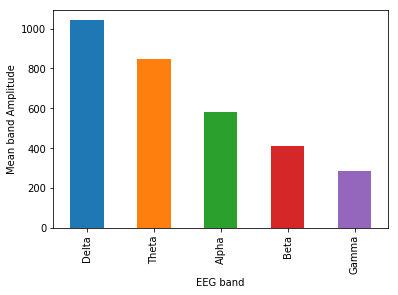

Opening raw data file /home/kovar/thesis_project/data/processed/65a.fif...
This filename (/home/kovar/thesis_project/data/processed/65a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19621 =      0.000 ...    78.484 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/65a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


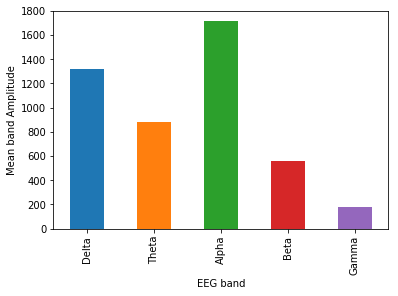

Opening raw data file /home/kovar/thesis_project/data/processed/124b.fif...
This filename (/home/kovar/thesis_project/data/processed/124b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 29934 =      0.000 ...   119.736 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/124b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


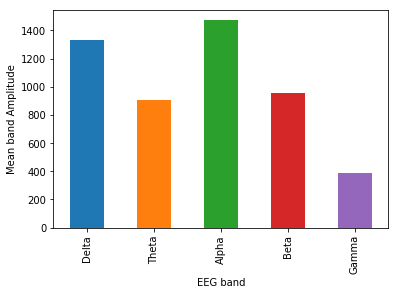

Opening raw data file /home/kovar/thesis_project/data/processed/55a.fif...
This filename (/home/kovar/thesis_project/data/processed/55a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19300 =      0.000 ...    77.200 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/55a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


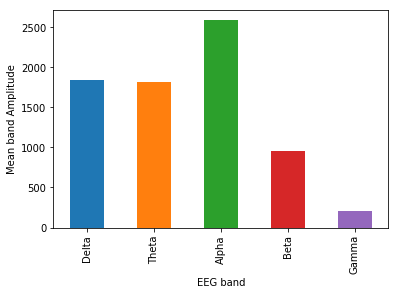

Opening raw data file /home/kovar/thesis_project/data/processed/42a.fif...
This filename (/home/kovar/thesis_project/data/processed/42a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 20327 =      0.000 ...    81.308 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/42a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


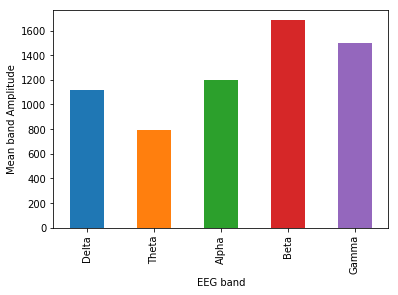

Opening raw data file /home/kovar/thesis_project/data/processed/59b.fif...
This filename (/home/kovar/thesis_project/data/processed/59b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 21931 =      0.000 ...    87.724 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/59b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


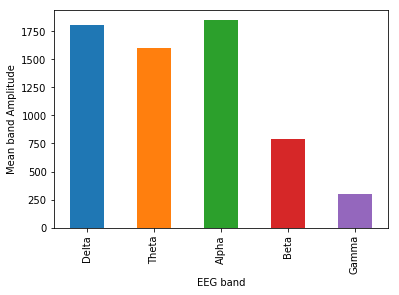

Opening raw data file /home/kovar/thesis_project/data/processed/8b.fif...
This filename (/home/kovar/thesis_project/data/processed/8b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 18645 =      0.000 ...    74.580 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/8b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


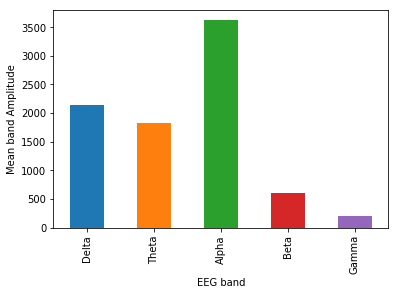

Opening raw data file /home/kovar/thesis_project/data/processed/54b.fif...
This filename (/home/kovar/thesis_project/data/processed/54b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 20654 =      0.000 ...    82.616 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/54b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


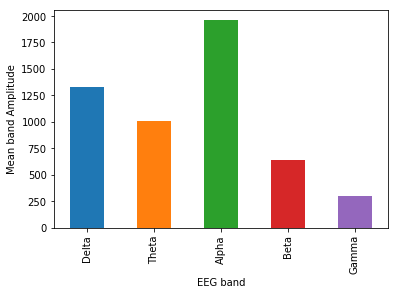

Opening raw data file /home/kovar/thesis_project/data/processed/62a.fif...
This filename (/home/kovar/thesis_project/data/processed/62a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 20123 =      0.000 ...    80.492 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/62a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


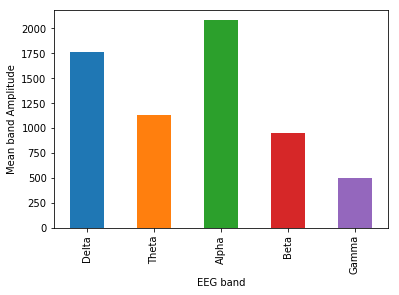

Opening raw data file /home/kovar/thesis_project/data/processed/106a.fif...
This filename (/home/kovar/thesis_project/data/processed/106a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 21133 =      0.000 ...    84.532 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/106a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


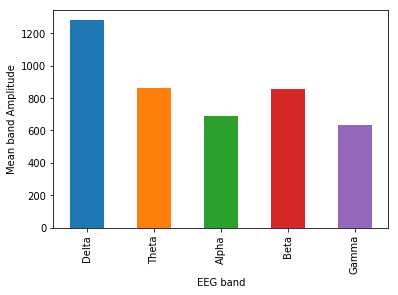

Opening raw data file /home/kovar/thesis_project/data/processed/63a.fif...
This filename (/home/kovar/thesis_project/data/processed/63a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15767 =      0.000 ...    63.068 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/63a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


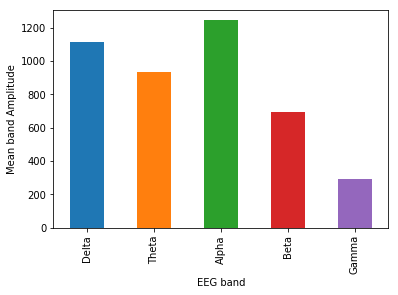

Opening raw data file /home/kovar/thesis_project/data/processed/41a.fif...
This filename (/home/kovar/thesis_project/data/processed/41a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 20905 =      0.000 ...    83.620 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/41a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


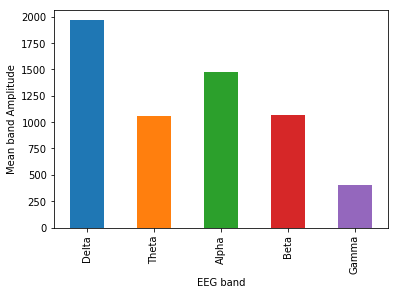

Opening raw data file /home/kovar/thesis_project/data/processed/119a.fif...
This filename (/home/kovar/thesis_project/data/processed/119a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 23879 =      0.000 ...    95.516 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/119a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


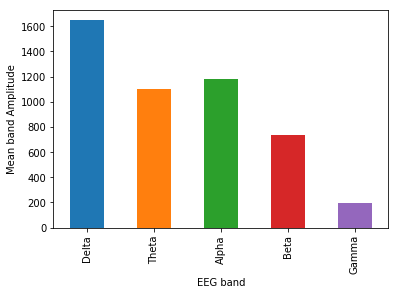

Opening raw data file /home/kovar/thesis_project/data/processed/54a.fif...
This filename (/home/kovar/thesis_project/data/processed/54a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15000 =      0.000 ...    60.000 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/54a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


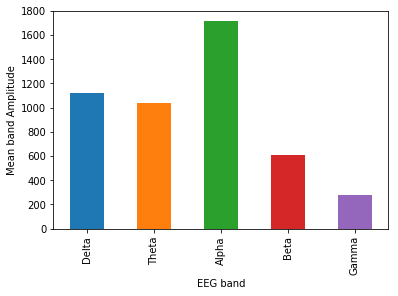

Opening raw data file /home/kovar/thesis_project/data/processed/22a.fif...
This filename (/home/kovar/thesis_project/data/processed/22a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16337 =      0.000 ...    65.348 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/22a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


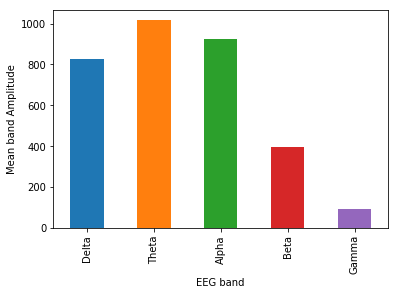

Opening raw data file /home/kovar/thesis_project/data/processed/93b.fif...
This filename (/home/kovar/thesis_project/data/processed/93b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16909 =      0.000 ...    67.636 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/93b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


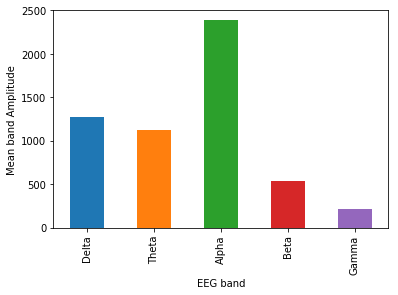

Opening raw data file /home/kovar/thesis_project/data/processed/43a.fif...
This filename (/home/kovar/thesis_project/data/processed/43a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 17211 =      0.000 ...    68.844 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/43a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


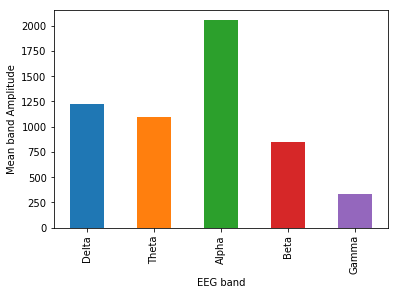

Opening raw data file /home/kovar/thesis_project/data/processed/127b.fif...
This filename (/home/kovar/thesis_project/data/processed/127b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15000 =      0.000 ...    60.000 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/127b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


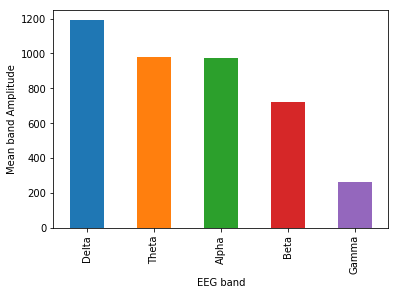

Opening raw data file /home/kovar/thesis_project/data/processed/24b.fif...
This filename (/home/kovar/thesis_project/data/processed/24b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 25142 =      0.000 ...   100.568 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/24b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


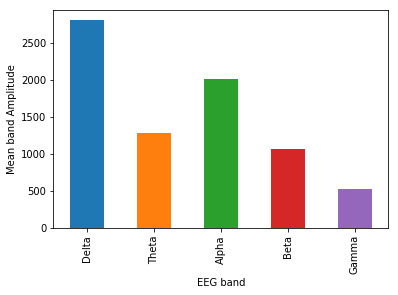

Opening raw data file /home/kovar/thesis_project/data/processed/88b.fif...
This filename (/home/kovar/thesis_project/data/processed/88b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 18050 =      0.000 ...    72.200 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/88b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


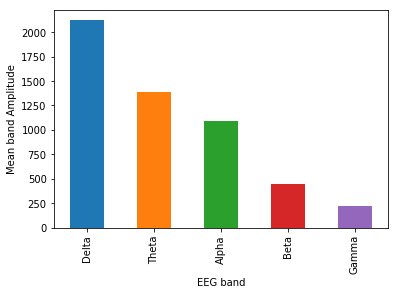

Opening raw data file /home/kovar/thesis_project/data/processed/31a.fif...
This filename (/home/kovar/thesis_project/data/processed/31a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15000 =      0.000 ...    60.000 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/31a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


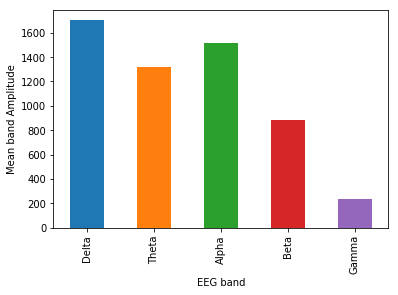

Opening raw data file /home/kovar/thesis_project/data/processed/35b.fif...
This filename (/home/kovar/thesis_project/data/processed/35b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 33885 =      0.000 ...   135.540 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/35b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


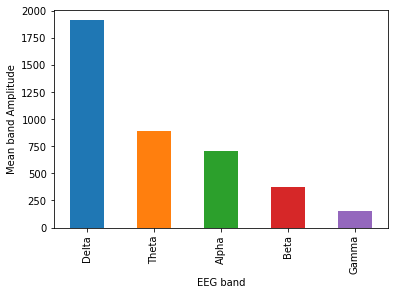

Opening raw data file /home/kovar/thesis_project/data/processed/38a.fif...
This filename (/home/kovar/thesis_project/data/processed/38a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19075 =      0.000 ...    76.300 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/38a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


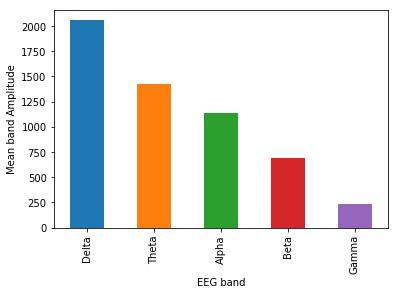

Opening raw data file /home/kovar/thesis_project/data/processed/68a.fif...
This filename (/home/kovar/thesis_project/data/processed/68a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 23228 =      0.000 ...    92.912 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/68a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


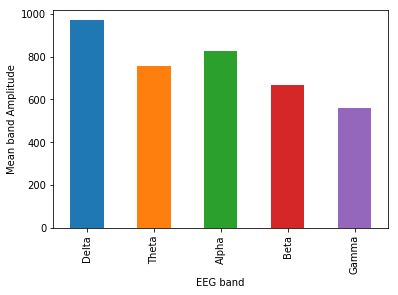

Opening raw data file /home/kovar/thesis_project/data/processed/41b.fif...
This filename (/home/kovar/thesis_project/data/processed/41b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 30651 =      0.000 ...   122.604 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/41b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


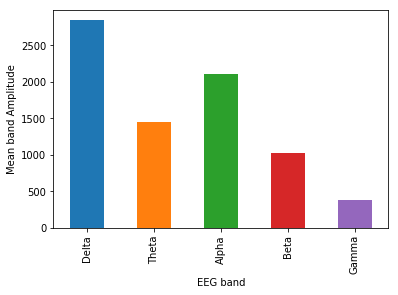

Opening raw data file /home/kovar/thesis_project/data/processed/121b.fif...
This filename (/home/kovar/thesis_project/data/processed/121b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 34195 =      0.000 ...   136.780 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/121b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


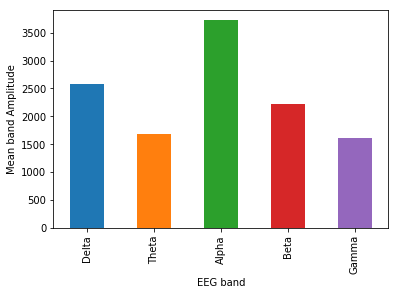

Opening raw data file /home/kovar/thesis_project/data/processed/66a.fif...
This filename (/home/kovar/thesis_project/data/processed/66a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 8669 =      0.000 ...    34.676 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/66a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


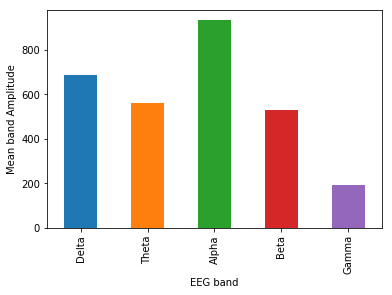

Opening raw data file /home/kovar/thesis_project/data/processed/21b.fif...
This filename (/home/kovar/thesis_project/data/processed/21b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 14712 =      0.000 ...    58.848 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/21b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


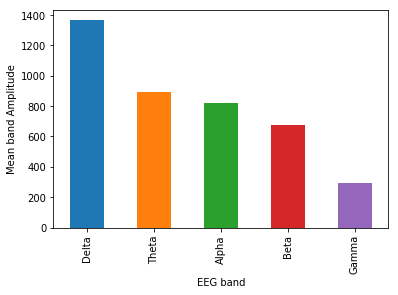

Opening raw data file /home/kovar/thesis_project/data/processed/103b.fif...
This filename (/home/kovar/thesis_project/data/processed/103b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 21146 =      0.000 ...    84.584 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/103b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


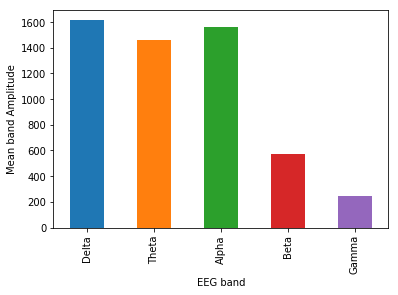

Opening raw data file /home/kovar/thesis_project/data/processed/52b.fif...
This filename (/home/kovar/thesis_project/data/processed/52b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 17763 =      0.000 ...    71.052 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/52b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


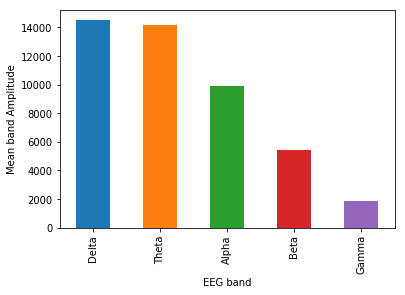

Opening raw data file /home/kovar/thesis_project/data/processed/84b.fif...
This filename (/home/kovar/thesis_project/data/processed/84b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16641 =      0.000 ...    66.564 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/84b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


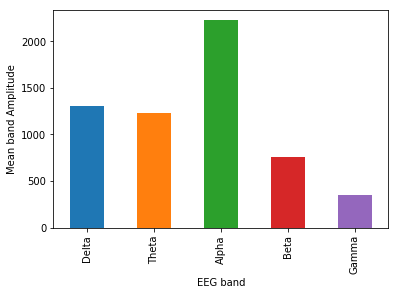

Opening raw data file /home/kovar/thesis_project/data/processed/77b.fif...
This filename (/home/kovar/thesis_project/data/processed/77b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15758 =      0.000 ...    63.032 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/77b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


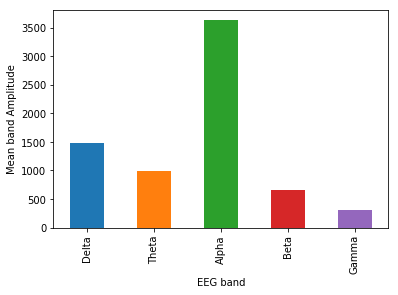

Opening raw data file /home/kovar/thesis_project/data/processed/18a.fif...
This filename (/home/kovar/thesis_project/data/processed/18a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 20560 =      0.000 ...    82.240 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/18a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


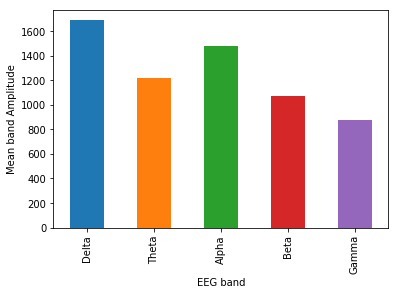

Opening raw data file /home/kovar/thesis_project/data/processed/113b.fif...
This filename (/home/kovar/thesis_project/data/processed/113b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 23870 =      0.000 ...    95.480 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/113b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


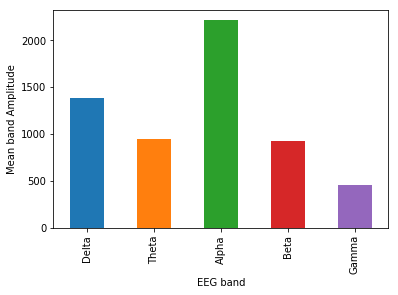

Opening raw data file /home/kovar/thesis_project/data/processed/3a.fif...
This filename (/home/kovar/thesis_project/data/processed/3a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 17064 =      0.000 ...    68.256 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/3a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


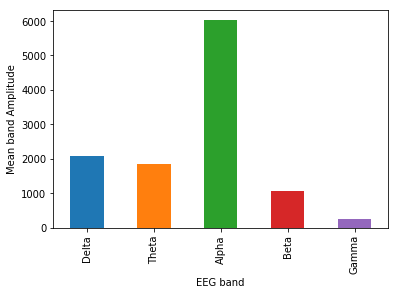

Opening raw data file /home/kovar/thesis_project/data/processed/13a.fif...
This filename (/home/kovar/thesis_project/data/processed/13a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 13129 =      0.000 ...    52.516 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/13a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


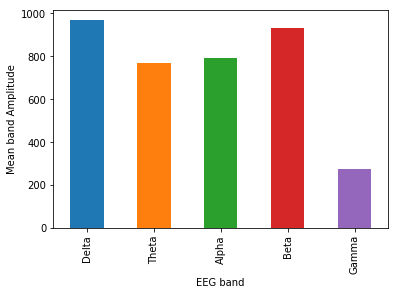

Opening raw data file /home/kovar/thesis_project/data/processed/64a.fif...
This filename (/home/kovar/thesis_project/data/processed/64a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15985 =      0.000 ...    63.940 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/64a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


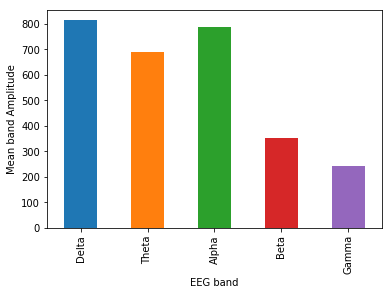

Opening raw data file /home/kovar/thesis_project/data/processed/39b.fif...
This filename (/home/kovar/thesis_project/data/processed/39b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15660 =      0.000 ...    62.640 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/39b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


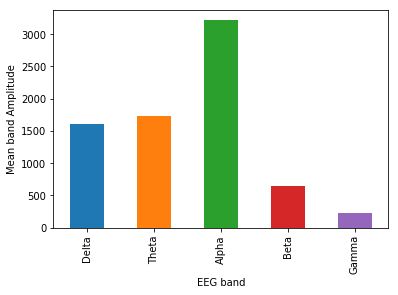

Opening raw data file /home/kovar/thesis_project/data/processed/128a.fif...
This filename (/home/kovar/thesis_project/data/processed/128a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15000 =      0.000 ...    60.000 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/128a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


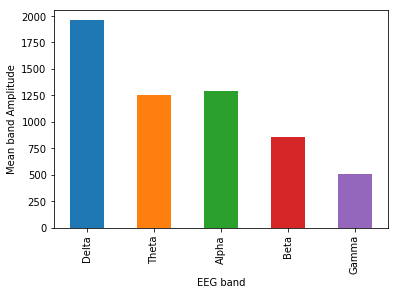

Opening raw data file /home/kovar/thesis_project/data/processed/25a.fif...
This filename (/home/kovar/thesis_project/data/processed/25a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16625 =      0.000 ...    66.500 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/25a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


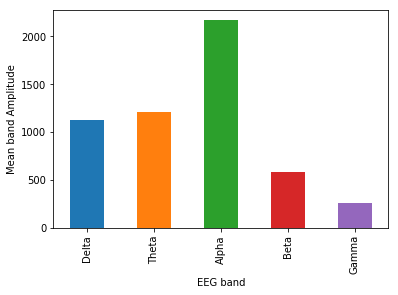

Opening raw data file /home/kovar/thesis_project/data/processed/99b.fif...
This filename (/home/kovar/thesis_project/data/processed/99b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16851 =      0.000 ...    67.404 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/99b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


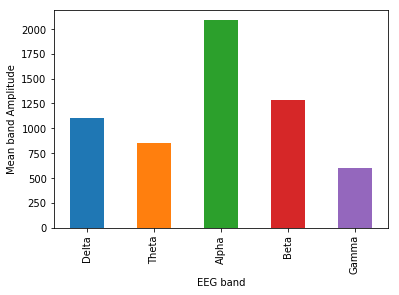

Opening raw data file /home/kovar/thesis_project/data/processed/20b.fif...
This filename (/home/kovar/thesis_project/data/processed/20b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15267 =      0.000 ...    61.068 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/20b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


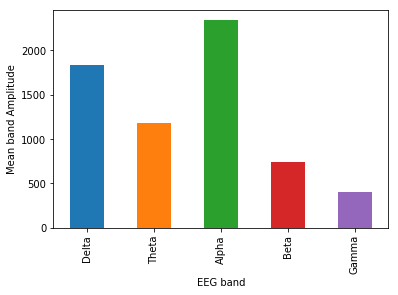

Opening raw data file /home/kovar/thesis_project/data/processed/28a.fif...
This filename (/home/kovar/thesis_project/data/processed/28a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15000 =      0.000 ...    60.000 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/28a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


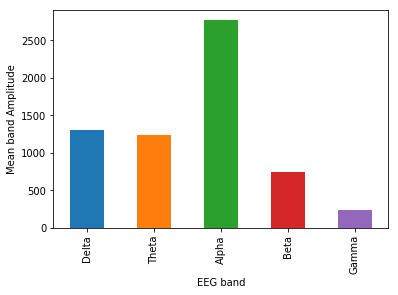

Opening raw data file /home/kovar/thesis_project/data/processed/62b.fif...
This filename (/home/kovar/thesis_project/data/processed/62b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 23683 =      0.000 ...    94.732 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/62b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


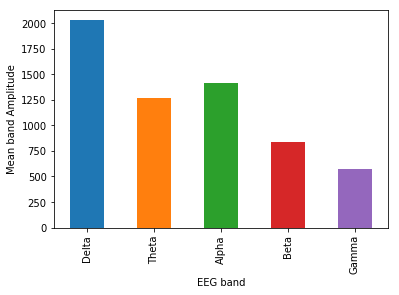

Opening raw data file /home/kovar/thesis_project/data/processed/28b.fif...
This filename (/home/kovar/thesis_project/data/processed/28b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 23525 =      0.000 ...    94.100 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/28b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


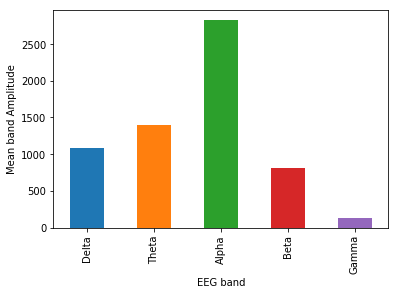

Opening raw data file /home/kovar/thesis_project/data/processed/105a.fif...
This filename (/home/kovar/thesis_project/data/processed/105a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 23128 =      0.000 ...    92.512 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/105a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


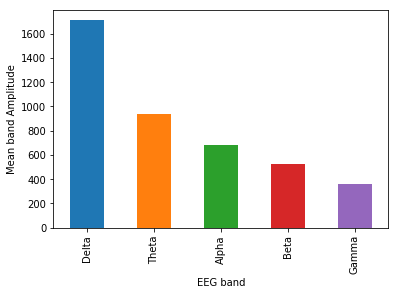

Opening raw data file /home/kovar/thesis_project/data/processed/109b.fif...
This filename (/home/kovar/thesis_project/data/processed/109b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15000 =      0.000 ...    60.000 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/109b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


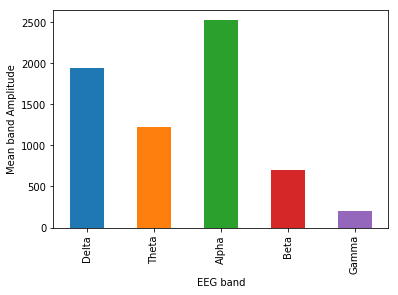

Opening raw data file /home/kovar/thesis_project/data/processed/117b.fif...
This filename (/home/kovar/thesis_project/data/processed/117b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 20358 =      0.000 ...    81.432 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/117b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


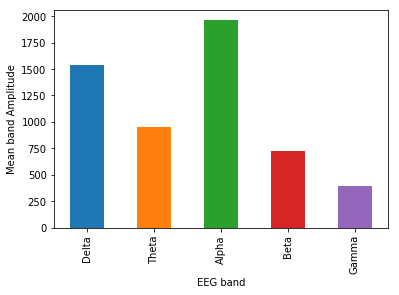

Opening raw data file /home/kovar/thesis_project/data/processed/98a.fif...
This filename (/home/kovar/thesis_project/data/processed/98a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 14235 =      0.000 ...    56.940 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/98a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


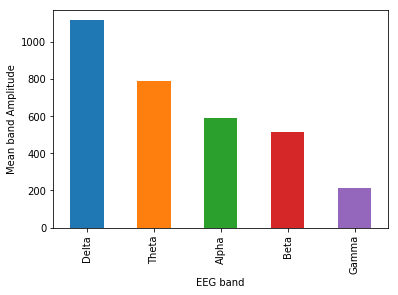

Opening raw data file /home/kovar/thesis_project/data/processed/64b.fif...
This filename (/home/kovar/thesis_project/data/processed/64b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15000 =      0.000 ...    60.000 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/64b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


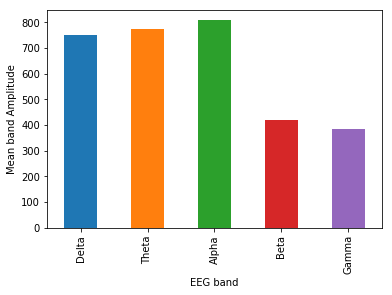

Opening raw data file /home/kovar/thesis_project/data/processed/98b.fif...
This filename (/home/kovar/thesis_project/data/processed/98b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 12829 =      0.000 ...    51.316 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/98b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


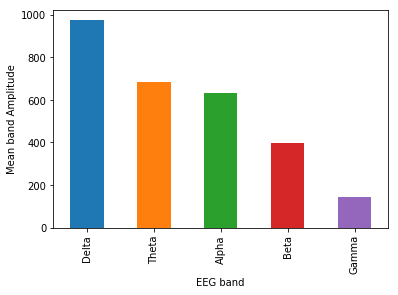

Opening raw data file /home/kovar/thesis_project/data/processed/2a.fif...
This filename (/home/kovar/thesis_project/data/processed/2a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 10598 =      0.000 ...    42.392 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/2a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


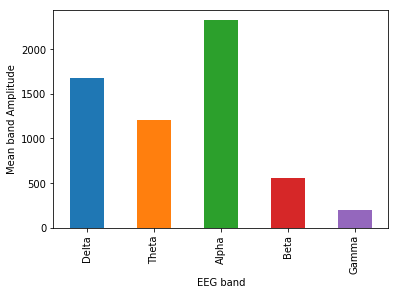

Opening raw data file /home/kovar/thesis_project/data/processed/90a.fif...
This filename (/home/kovar/thesis_project/data/processed/90a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/90a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


Isotrak not found
    Range : 0 ... 22607 =      0.000 ...    90.428 secs
Ready.


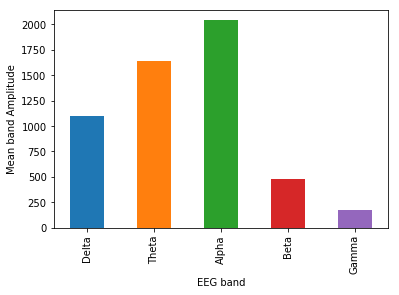

Opening raw data file /home/kovar/thesis_project/data/processed/5a.fif...
This filename (/home/kovar/thesis_project/data/processed/5a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 30656 =      0.000 ...   122.624 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/5a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


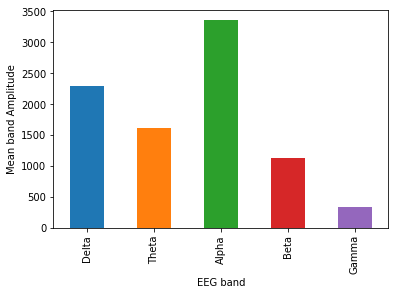

Opening raw data file /home/kovar/thesis_project/data/processed/108a.fif...
This filename (/home/kovar/thesis_project/data/processed/108a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 18239 =      0.000 ...    72.956 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/108a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


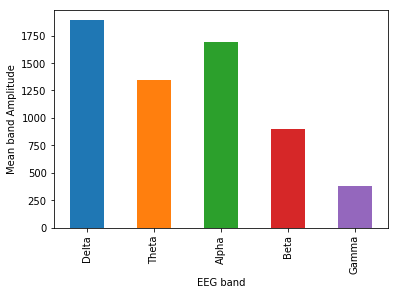

Opening raw data file /home/kovar/thesis_project/data/processed/34a.fif...
This filename (/home/kovar/thesis_project/data/processed/34a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 20242 =      0.000 ...    80.968 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/34a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


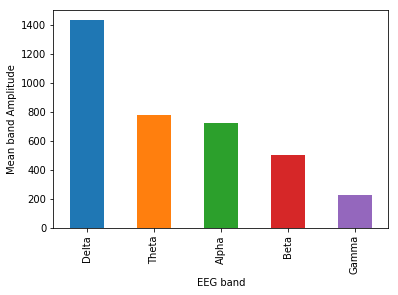

Opening raw data file /home/kovar/thesis_project/data/processed/92b.fif...
This filename (/home/kovar/thesis_project/data/processed/92b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16104 =      0.000 ...    64.416 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/92b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


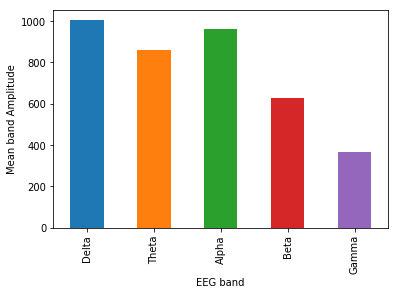

Opening raw data file /home/kovar/thesis_project/data/processed/70a.fif...
This filename (/home/kovar/thesis_project/data/processed/70a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 14707 =      0.000 ...    58.828 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/70a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


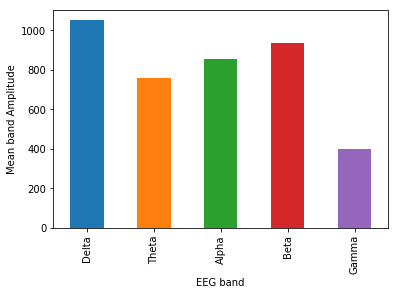

Opening raw data file /home/kovar/thesis_project/data/processed/32a.fif...
This filename (/home/kovar/thesis_project/data/processed/32a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15941 =      0.000 ...    63.764 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/32a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


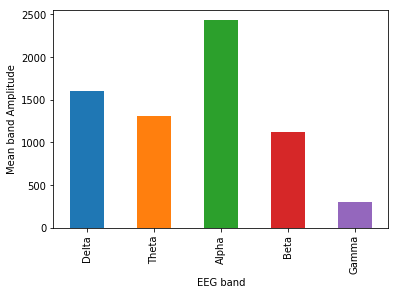

Opening raw data file /home/kovar/thesis_project/data/processed/51b.fif...
This filename (/home/kovar/thesis_project/data/processed/51b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19058 =      0.000 ...    76.232 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/51b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


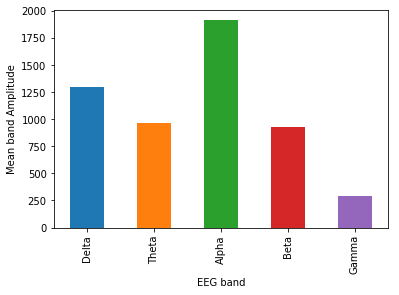

Opening raw data file /home/kovar/thesis_project/data/processed/133a.fif...
This filename (/home/kovar/thesis_project/data/processed/133a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 20961 =      0.000 ...    83.844 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/133a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


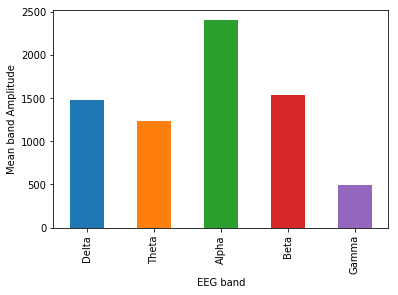

Opening raw data file /home/kovar/thesis_project/data/processed/8a.fif...
This filename (/home/kovar/thesis_project/data/processed/8a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 14392 =      0.000 ...    57.568 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/8a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


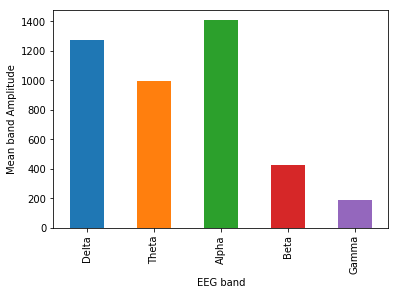

Opening raw data file /home/kovar/thesis_project/data/processed/107b.fif...
This filename (/home/kovar/thesis_project/data/processed/107b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15000 =      0.000 ...    60.000 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/107b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


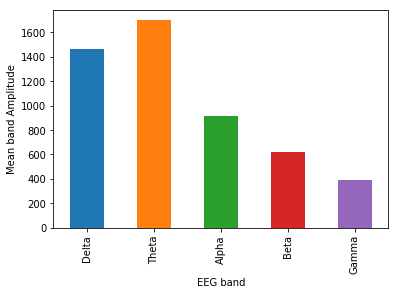

Opening raw data file /home/kovar/thesis_project/data/processed/128b.fif...
This filename (/home/kovar/thesis_project/data/processed/128b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 11594 =      0.000 ...    46.376 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/128b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


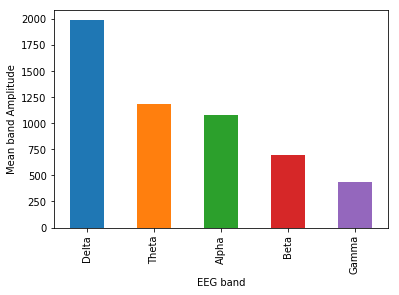

Opening raw data file /home/kovar/thesis_project/data/processed/103a.fif...
This filename (/home/kovar/thesis_project/data/processed/103a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15000 =      0.000 ...    60.000 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/103a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


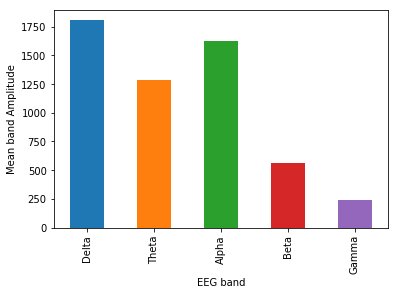

Opening raw data file /home/kovar/thesis_project/data/processed/13b.fif...
This filename (/home/kovar/thesis_project/data/processed/13b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15292 =      0.000 ...    61.168 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/13b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


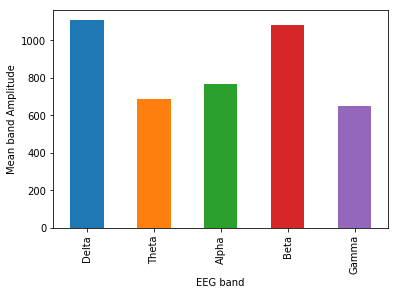

Opening raw data file /home/kovar/thesis_project/data/processed/129b.fif...
This filename (/home/kovar/thesis_project/data/processed/129b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15000 =      0.000 ...    60.000 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/129b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


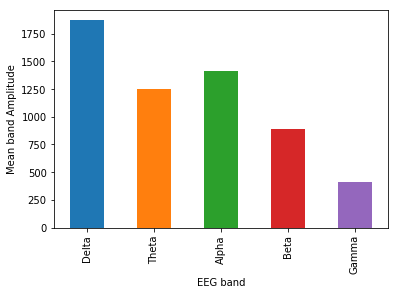

Opening raw data file /home/kovar/thesis_project/data/processed/114b.fif...
This filename (/home/kovar/thesis_project/data/processed/114b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 20021 =      0.000 ...    80.084 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/114b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


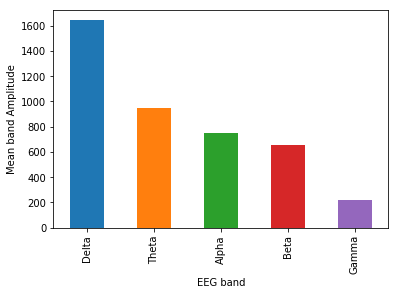

Opening raw data file /home/kovar/thesis_project/data/processed/60b.fif...
This filename (/home/kovar/thesis_project/data/processed/60b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15692 =      0.000 ...    62.768 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/60b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


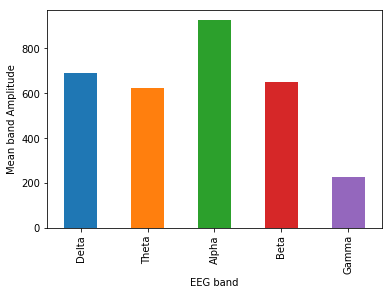

Opening raw data file /home/kovar/thesis_project/data/processed/37a.fif...
This filename (/home/kovar/thesis_project/data/processed/37a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 27423 =      0.000 ...   109.692 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/37a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


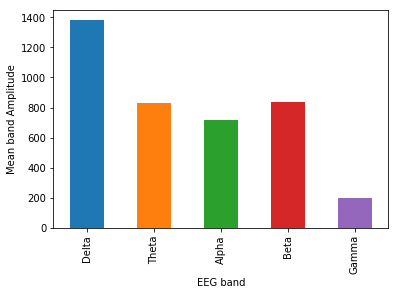

Opening raw data file /home/kovar/thesis_project/data/processed/14b.fif...
This filename (/home/kovar/thesis_project/data/processed/14b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19516 =      0.000 ...    78.064 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/14b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


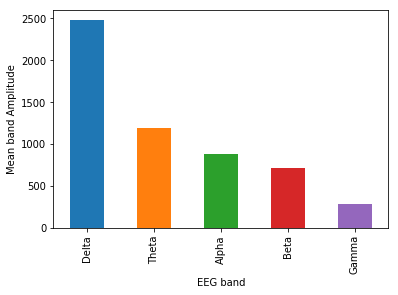

Opening raw data file /home/kovar/thesis_project/data/processed/52a.fif...
This filename (/home/kovar/thesis_project/data/processed/52a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15000 =      0.000 ...    60.000 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/52a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


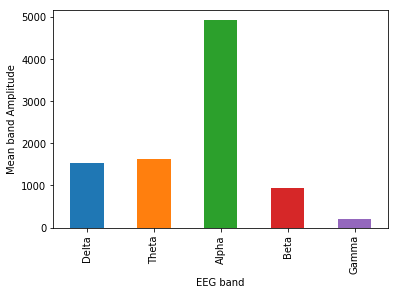

Opening raw data file /home/kovar/thesis_project/data/processed/24a.fif...
This filename (/home/kovar/thesis_project/data/processed/24a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 23916 =      0.000 ...    95.664 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/24a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


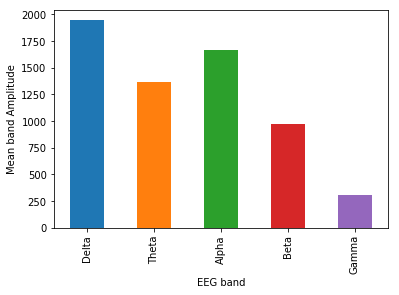

Opening raw data file /home/kovar/thesis_project/data/processed/120b.fif...
This filename (/home/kovar/thesis_project/data/processed/120b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 12209 =      0.000 ...    48.836 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/120b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


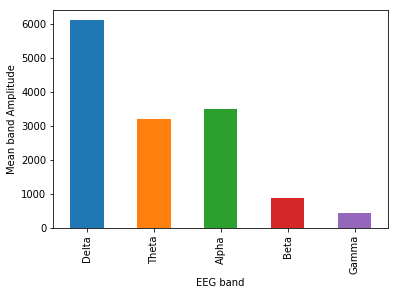

Opening raw data file /home/kovar/thesis_project/data/processed/115a.fif...
This filename (/home/kovar/thesis_project/data/processed/115a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 28996 =      0.000 ...   115.984 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/115a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


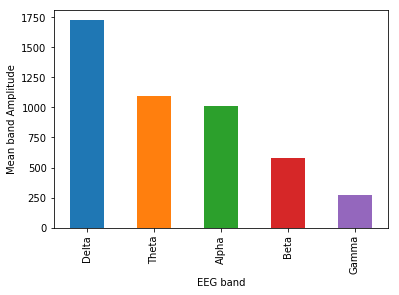

Opening raw data file /home/kovar/thesis_project/data/processed/76b.fif...
This filename (/home/kovar/thesis_project/data/processed/76b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15097 =      0.000 ...    60.388 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/76b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


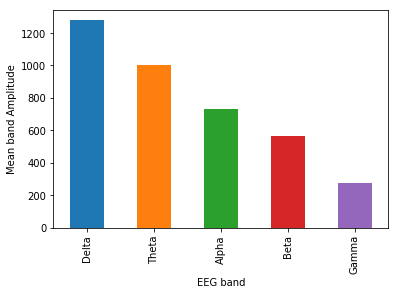

Opening raw data file /home/kovar/thesis_project/data/processed/76a.fif...
This filename (/home/kovar/thesis_project/data/processed/76a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15263 =      0.000 ...    61.052 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/76a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


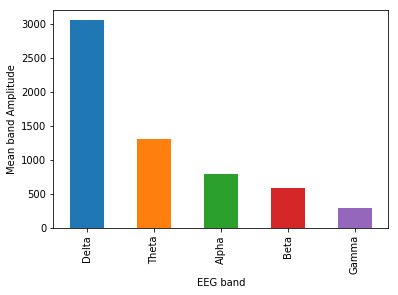

Opening raw data file /home/kovar/thesis_project/data/processed/37b.fif...
This filename (/home/kovar/thesis_project/data/processed/37b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15252 =      0.000 ...    61.008 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/37b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


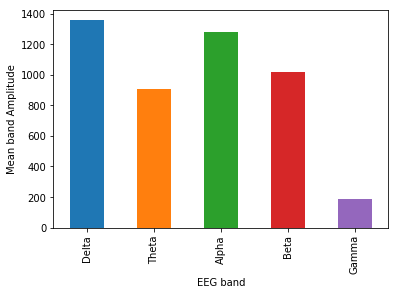

Opening raw data file /home/kovar/thesis_project/data/processed/44b.fif...
This filename (/home/kovar/thesis_project/data/processed/44b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 22121 =      0.000 ...    88.484 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/44b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


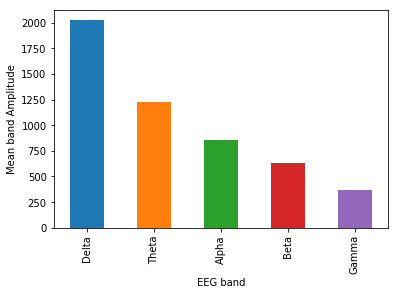

Opening raw data file /home/kovar/thesis_project/data/processed/78b.fif...
This filename (/home/kovar/thesis_project/data/processed/78b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15851 =      0.000 ...    63.404 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/78b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


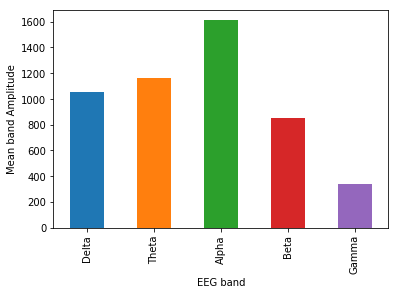

Opening raw data file /home/kovar/thesis_project/data/processed/121a.fif...
This filename (/home/kovar/thesis_project/data/processed/121a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 21453 =      0.000 ...    85.812 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/121a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


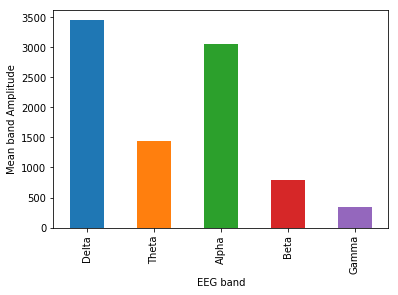

Opening raw data file /home/kovar/thesis_project/data/processed/74a.fif...
This filename (/home/kovar/thesis_project/data/processed/74a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 18654 =      0.000 ...    74.616 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/74a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


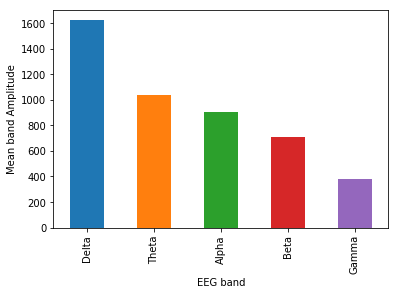

Opening raw data file /home/kovar/thesis_project/data/processed/36b.fif...
This filename (/home/kovar/thesis_project/data/processed/36b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19812 =      0.000 ...    79.248 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/36b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


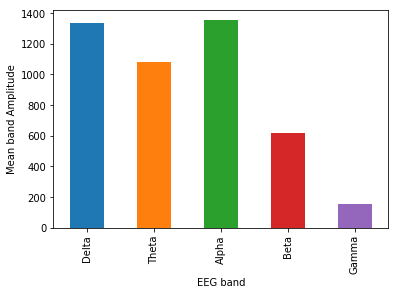

Opening raw data file /home/kovar/thesis_project/data/processed/15b.fif...
This filename (/home/kovar/thesis_project/data/processed/15b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 18969 =      0.000 ...    75.876 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/15b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


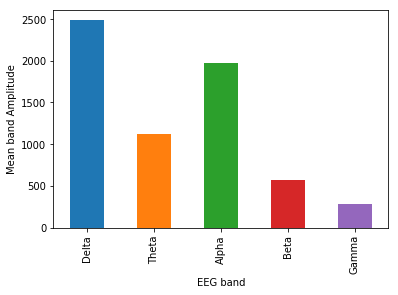

Opening raw data file /home/kovar/thesis_project/data/processed/16a.fif...
This filename (/home/kovar/thesis_project/data/processed/16a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15255 =      0.000 ...    61.020 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/16a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


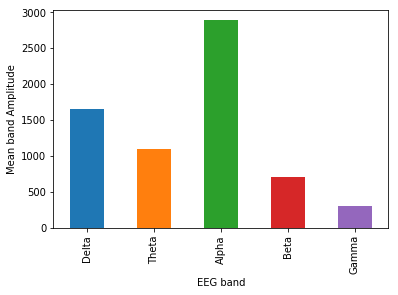

Opening raw data file /home/kovar/thesis_project/data/processed/123b.fif...
This filename (/home/kovar/thesis_project/data/processed/123b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 25961 =      0.000 ...   103.844 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/123b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


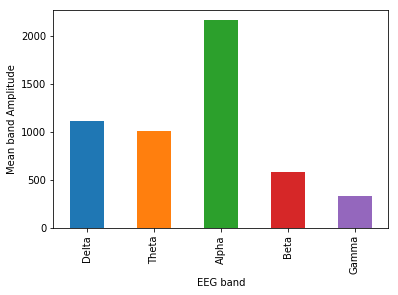

Opening raw data file /home/kovar/thesis_project/data/processed/77a.fif...
This filename (/home/kovar/thesis_project/data/processed/77a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 18386 =      0.000 ...    73.544 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/77a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


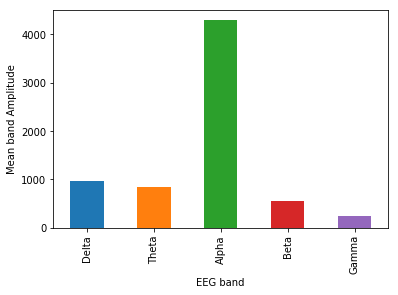

Opening raw data file /home/kovar/thesis_project/data/processed/83b.fif...
This filename (/home/kovar/thesis_project/data/processed/83b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 18158 =      0.000 ...    72.632 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/83b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


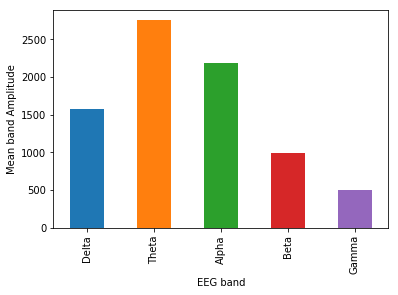

Opening raw data file /home/kovar/thesis_project/data/processed/56a.fif...
This filename (/home/kovar/thesis_project/data/processed/56a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15511 =      0.000 ...    62.044 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/56a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


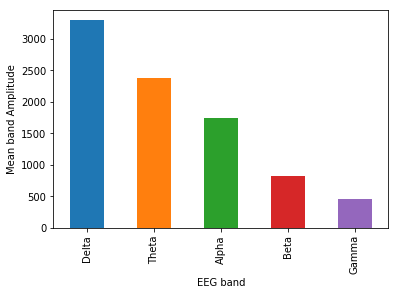

Opening raw data file /home/kovar/thesis_project/data/processed/116b.fif...
This filename (/home/kovar/thesis_project/data/processed/116b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16734 =      0.000 ...    66.936 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/116b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


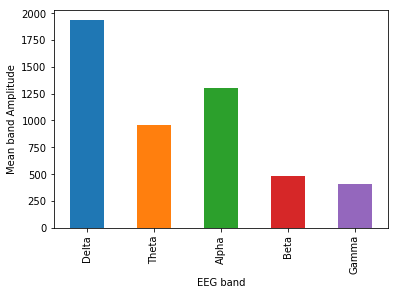

Opening raw data file /home/kovar/thesis_project/data/processed/33b.fif...
This filename (/home/kovar/thesis_project/data/processed/33b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 22941 =      0.000 ...    91.764 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/33b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


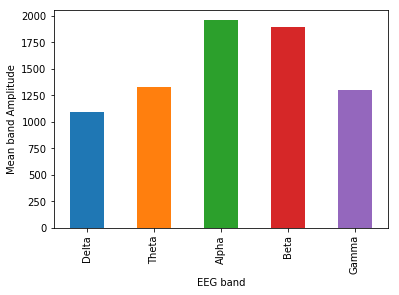

Opening raw data file /home/kovar/thesis_project/data/processed/47a.fif...
This filename (/home/kovar/thesis_project/data/processed/47a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 26145 =      0.000 ...   104.580 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/47a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


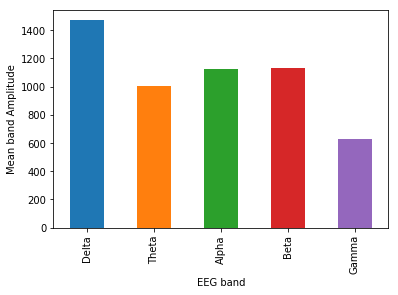

Opening raw data file /home/kovar/thesis_project/data/processed/117a.fif...
This filename (/home/kovar/thesis_project/data/processed/117a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 18082 =      0.000 ...    72.328 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/117a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


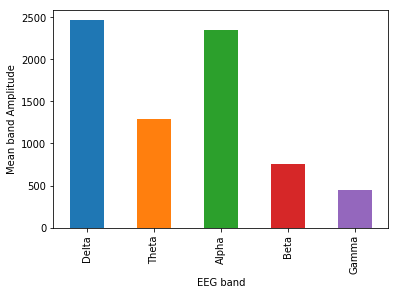

Opening raw data file /home/kovar/thesis_project/data/processed/19a.fif...
This filename (/home/kovar/thesis_project/data/processed/19a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16050 =      0.000 ...    64.200 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/19a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


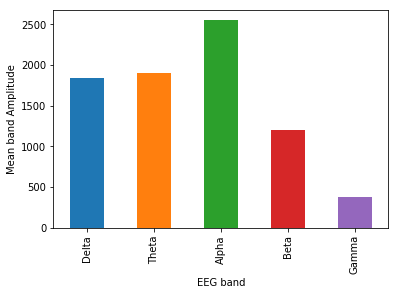

Opening raw data file /home/kovar/thesis_project/data/processed/101a.fif...
This filename (/home/kovar/thesis_project/data/processed/101a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 11823 =      0.000 ...    47.292 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/101a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


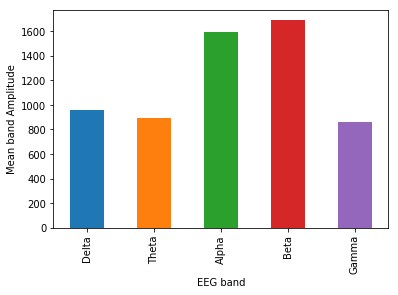

Opening raw data file /home/kovar/thesis_project/data/processed/57b.fif...
This filename (/home/kovar/thesis_project/data/processed/57b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15681 =      0.000 ...    62.724 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/57b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


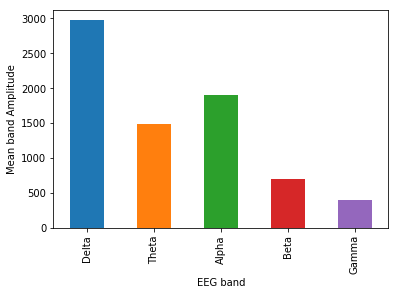

Opening raw data file /home/kovar/thesis_project/data/processed/48a.fif...
This filename (/home/kovar/thesis_project/data/processed/48a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 21401 =      0.000 ...    85.604 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/48a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


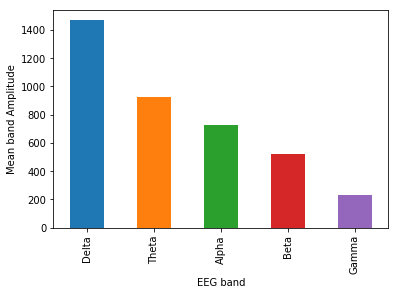

Opening raw data file /home/kovar/thesis_project/data/processed/132b.fif...
This filename (/home/kovar/thesis_project/data/processed/132b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 33615 =      0.000 ...   134.460 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/132b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


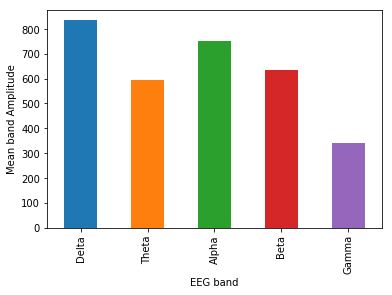

Opening raw data file /home/kovar/thesis_project/data/processed/116a.fif...
This filename (/home/kovar/thesis_project/data/processed/116a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15695 =      0.000 ...    62.780 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/116a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


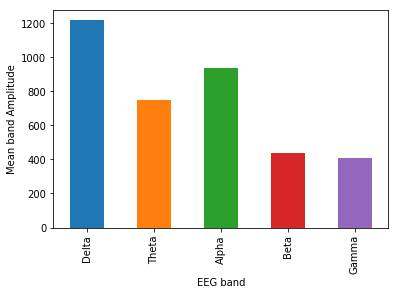

Opening raw data file /home/kovar/thesis_project/data/processed/127a.fif...
This filename (/home/kovar/thesis_project/data/processed/127a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 25087 =      0.000 ...   100.348 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/127a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


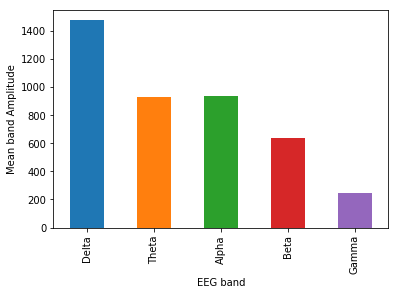

Opening raw data file /home/kovar/thesis_project/data/processed/45a.fif...
This filename (/home/kovar/thesis_project/data/processed/45a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15800 =      0.000 ...    63.200 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/45a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


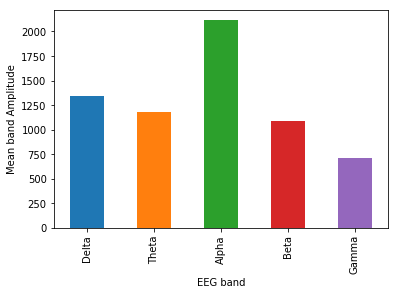

Opening raw data file /home/kovar/thesis_project/data/processed/23b.fif...
This filename (/home/kovar/thesis_project/data/processed/23b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 21450 =      0.000 ...    85.800 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/23b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


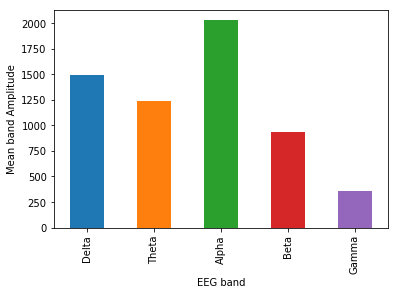

Opening raw data file /home/kovar/thesis_project/data/processed/71a.fif...
This filename (/home/kovar/thesis_project/data/processed/71a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19188 =      0.000 ...    76.752 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/71a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


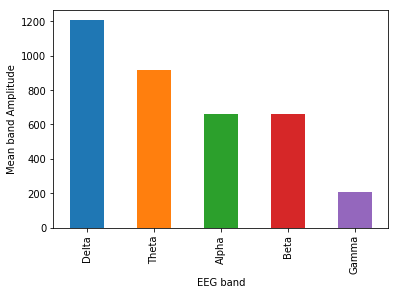

Opening raw data file /home/kovar/thesis_project/data/processed/65b.fif...
This filename (/home/kovar/thesis_project/data/processed/65b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 17318 =      0.000 ...    69.272 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/65b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


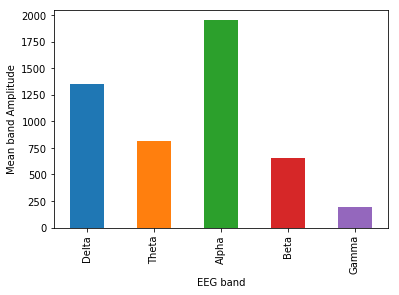

Opening raw data file /home/kovar/thesis_project/data/processed/2b.fif...
This filename (/home/kovar/thesis_project/data/processed/2b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 17652 =      0.000 ...    70.608 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/2b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


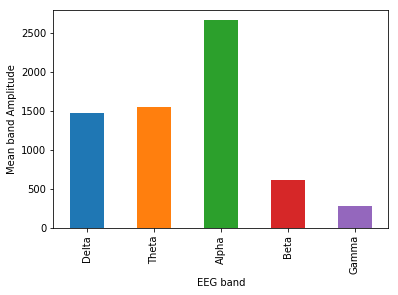

Opening raw data file /home/kovar/thesis_project/data/processed/42b.fif...
This filename (/home/kovar/thesis_project/data/processed/42b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19952 =      0.000 ...    79.808 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/42b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


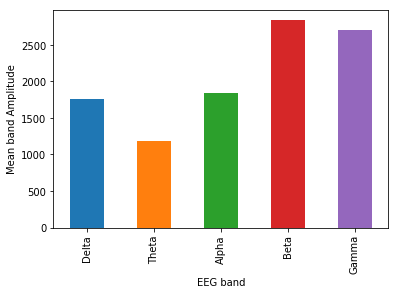

Opening raw data file /home/kovar/thesis_project/data/processed/1a.fif...
This filename (/home/kovar/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19104 =      0.000 ...    76.416 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


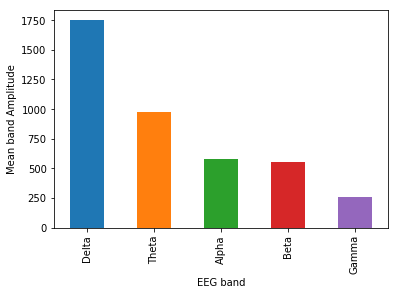

Opening raw data file /home/kovar/thesis_project/data/processed/100a.fif...
This filename (/home/kovar/thesis_project/data/processed/100a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 12393 =      0.000 ...    49.572 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/100a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


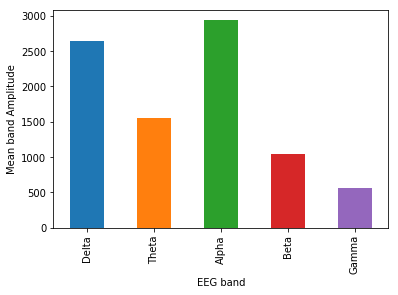

Opening raw data file /home/kovar/thesis_project/data/processed/99a.fif...
This filename (/home/kovar/thesis_project/data/processed/99a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19691 =      0.000 ...    78.764 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/99a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


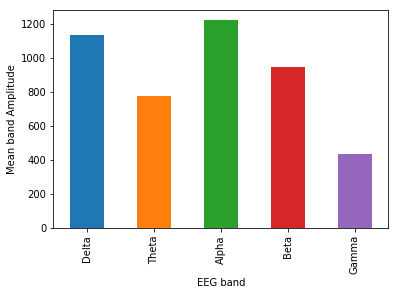

Opening raw data file /home/kovar/thesis_project/data/processed/58b.fif...
This filename (/home/kovar/thesis_project/data/processed/58b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19664 =      0.000 ...    78.656 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/58b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


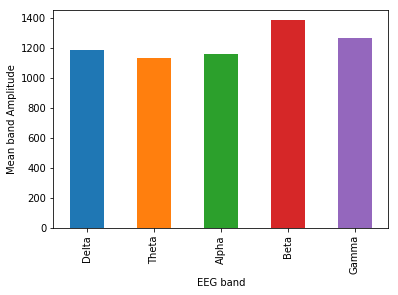

Opening raw data file /home/kovar/thesis_project/data/processed/120a.fif...
This filename (/home/kovar/thesis_project/data/processed/120a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16061 =      0.000 ...    64.244 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/120a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


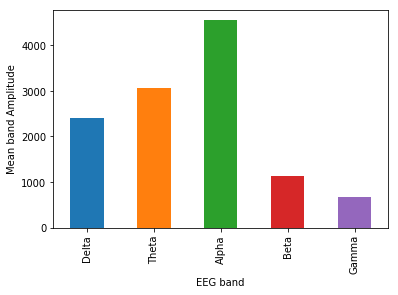

Opening raw data file /home/kovar/thesis_project/data/processed/56b.fif...
This filename (/home/kovar/thesis_project/data/processed/56b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 25134 =      0.000 ...   100.536 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/56b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


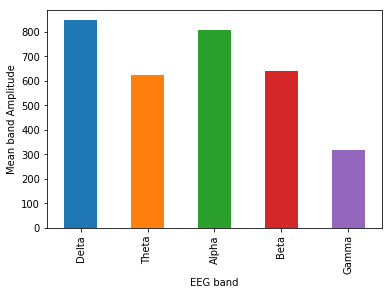

Opening raw data file /home/kovar/thesis_project/data/processed/91b.fif...
This filename (/home/kovar/thesis_project/data/processed/91b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15000 =      0.000 ...    60.000 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/91b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


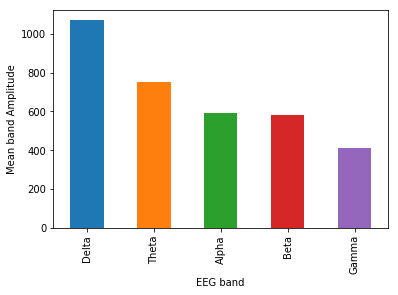

Opening raw data file /home/kovar/thesis_project/data/processed/53a.fif...
This filename (/home/kovar/thesis_project/data/processed/53a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 14736 =      0.000 ...    58.944 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/53a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


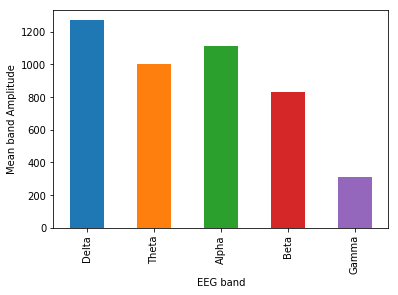

Opening raw data file /home/kovar/thesis_project/data/processed/75a.fif...
This filename (/home/kovar/thesis_project/data/processed/75a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 18892 =      0.000 ...    75.568 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/75a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


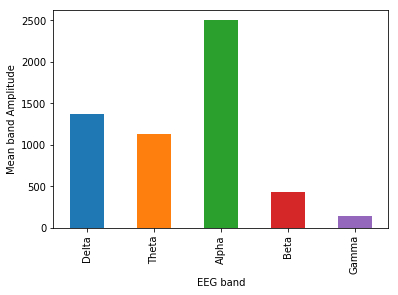

Opening raw data file /home/kovar/thesis_project/data/processed/43b.fif...
This filename (/home/kovar/thesis_project/data/processed/43b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15846 =      0.000 ...    63.384 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/43b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


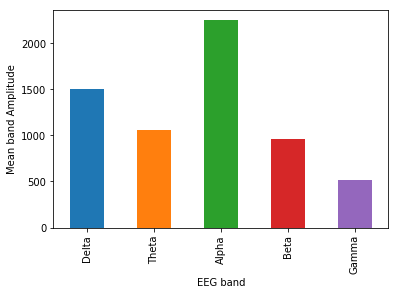

Opening raw data file /home/kovar/thesis_project/data/processed/23a.fif...
This filename (/home/kovar/thesis_project/data/processed/23a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 21208 =      0.000 ...    84.832 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/23a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


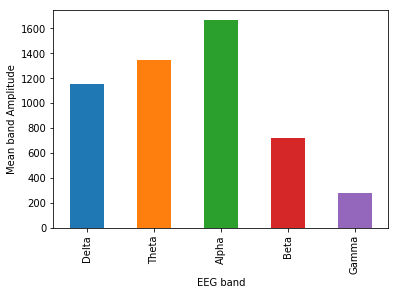

Opening raw data file /home/kovar/thesis_project/data/processed/58a.fif...
This filename (/home/kovar/thesis_project/data/processed/58a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19372 =      0.000 ...    77.488 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/58a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


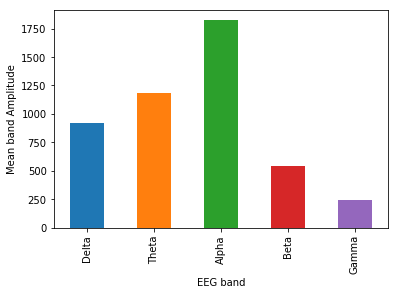

Opening raw data file /home/kovar/thesis_project/data/processed/10a.fif...
This filename (/home/kovar/thesis_project/data/processed/10a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 18472 =      0.000 ...    73.888 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/10a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


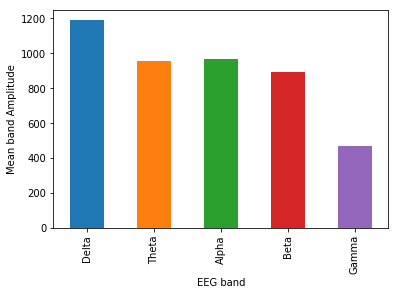

Opening raw data file /home/kovar/thesis_project/data/processed/89b.fif...
This filename (/home/kovar/thesis_project/data/processed/89b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 26917 =      0.000 ...   107.668 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/89b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


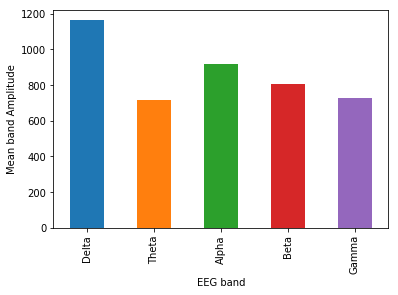

Opening raw data file /home/kovar/thesis_project/data/processed/100b.fif...
This filename (/home/kovar/thesis_project/data/processed/100b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 17015 =      0.000 ...    68.060 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/100b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


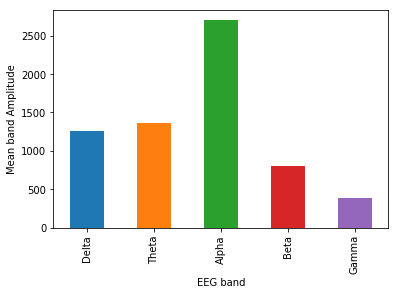

Opening raw data file /home/kovar/thesis_project/data/processed/126b.fif...
This filename (/home/kovar/thesis_project/data/processed/126b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 18722 =      0.000 ...    74.888 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/126b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


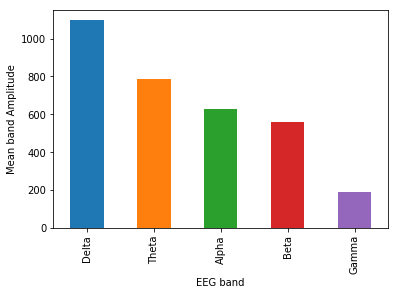

Opening raw data file /home/kovar/thesis_project/data/processed/72a.fif...
This filename (/home/kovar/thesis_project/data/processed/72a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16666 =      0.000 ...    66.664 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/72a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


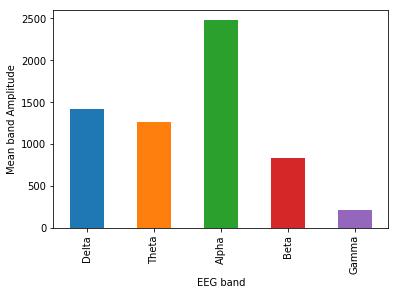

Opening raw data file /home/kovar/thesis_project/data/processed/68b.fif...
This filename (/home/kovar/thesis_project/data/processed/68b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 23068 =      0.000 ...    92.272 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/68b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


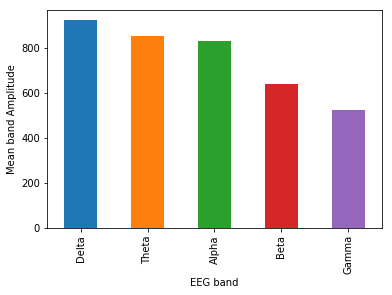

Opening raw data file /home/kovar/thesis_project/data/processed/115b.fif...
This filename (/home/kovar/thesis_project/data/processed/115b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19586 =      0.000 ...    78.344 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/115b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


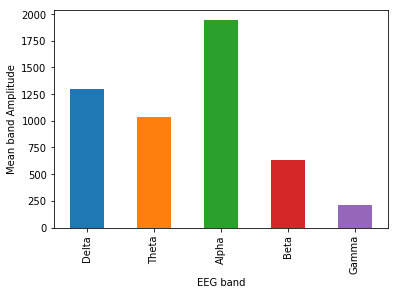

Opening raw data file /home/kovar/thesis_project/data/processed/104b.fif...
This filename (/home/kovar/thesis_project/data/processed/104b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16885 =      0.000 ...    67.540 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/104b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


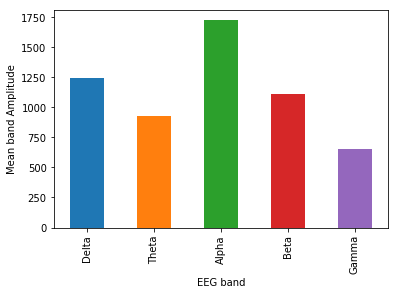

Opening raw data file /home/kovar/thesis_project/data/processed/67b.fif...
This filename (/home/kovar/thesis_project/data/processed/67b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 17764 =      0.000 ...    71.056 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/67b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


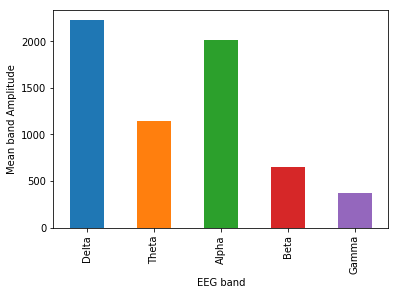

Opening raw data file /home/kovar/thesis_project/data/processed/66b.fif...
This filename (/home/kovar/thesis_project/data/processed/66b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 12931 =      0.000 ...    51.724 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/66b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


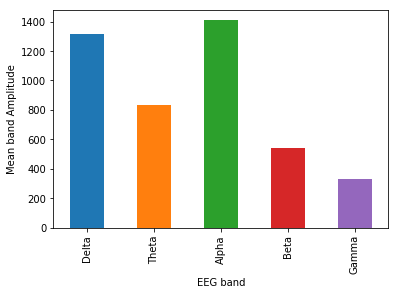

Opening raw data file /home/kovar/thesis_project/data/processed/30b.fif...
This filename (/home/kovar/thesis_project/data/processed/30b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 17610 =      0.000 ...    70.440 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/30b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


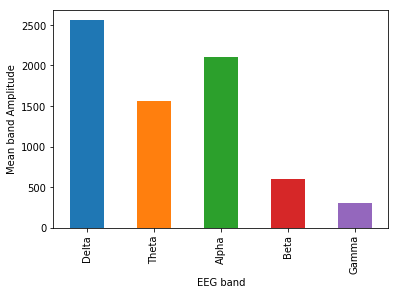

Opening raw data file /home/kovar/thesis_project/data/processed/123a.fif...
This filename (/home/kovar/thesis_project/data/processed/123a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16044 =      0.000 ...    64.176 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/123a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


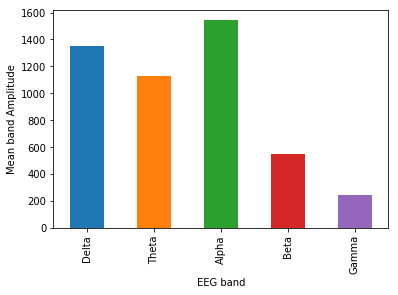

Opening raw data file /home/kovar/thesis_project/data/processed/48b.fif...
This filename (/home/kovar/thesis_project/data/processed/48b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19357 =      0.000 ...    77.428 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/48b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


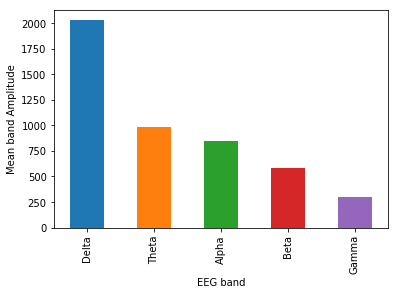

Opening raw data file /home/kovar/thesis_project/data/processed/108b.fif...
This filename (/home/kovar/thesis_project/data/processed/108b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 20868 =      0.000 ...    83.472 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/108b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


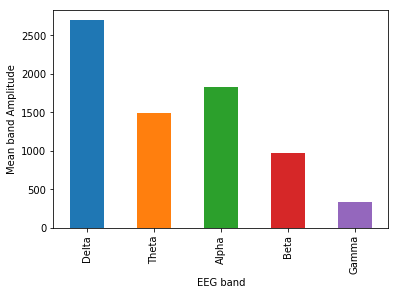

Opening raw data file /home/kovar/thesis_project/data/processed/86b.fif...
This filename (/home/kovar/thesis_project/data/processed/86b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16216 =      0.000 ...    64.864 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/86b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


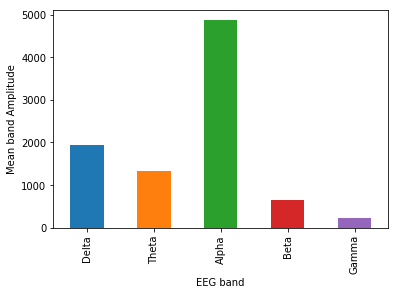

Opening raw data file /home/kovar/thesis_project/data/processed/109a.fif...
This filename (/home/kovar/thesis_project/data/processed/109a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 27887 =      0.000 ...   111.548 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/109a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


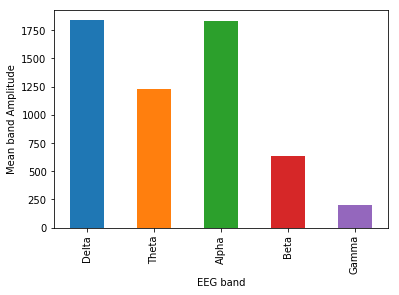

Opening raw data file /home/kovar/thesis_project/data/processed/124a.fif...
This filename (/home/kovar/thesis_project/data/processed/124a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 31310 =      0.000 ...   125.240 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/124a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


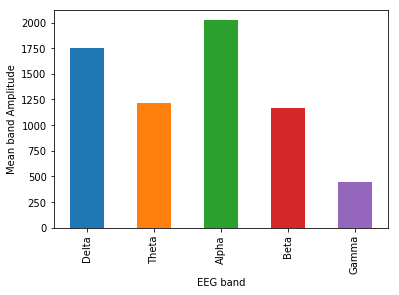

Opening raw data file /home/kovar/thesis_project/data/processed/3b.fif...
This filename (/home/kovar/thesis_project/data/processed/3b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16223 =      0.000 ...    64.892 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/3b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


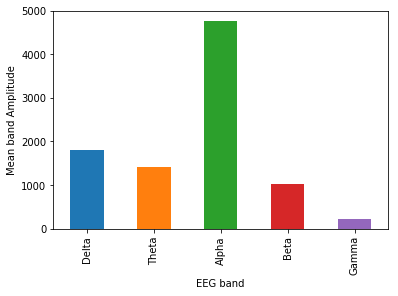

Opening raw data file /home/kovar/thesis_project/data/processed/55b.fif...
This filename (/home/kovar/thesis_project/data/processed/55b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19128 =      0.000 ...    76.512 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/55b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


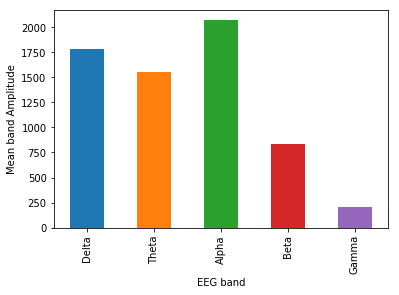

Opening raw data file /home/kovar/thesis_project/data/processed/29b.fif...
This filename (/home/kovar/thesis_project/data/processed/29b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 17889 =      0.000 ...    71.556 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/29b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


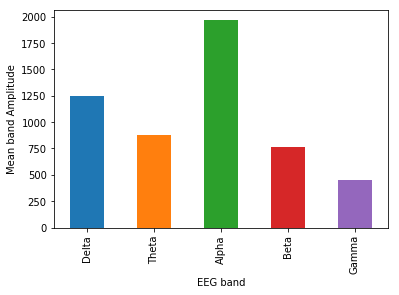

Opening raw data file /home/kovar/thesis_project/data/processed/6a.fif...
This filename (/home/kovar/thesis_project/data/processed/6a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 13421 =      0.000 ...    53.684 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/6a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


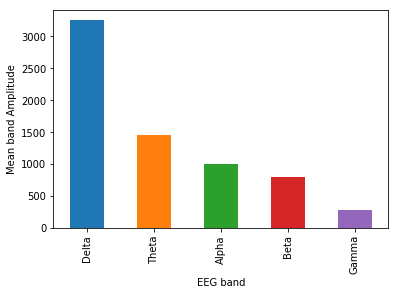

Opening raw data file /home/kovar/thesis_project/data/processed/81a.fif...
This filename (/home/kovar/thesis_project/data/processed/81a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16149 =      0.000 ...    64.596 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/81a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


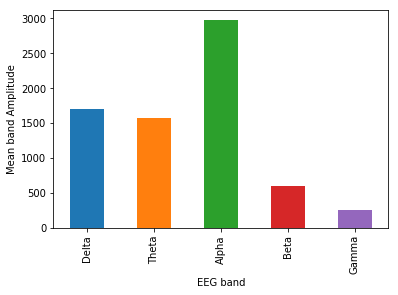

Opening raw data file /home/kovar/thesis_project/data/processed/47b.fif...
This filename (/home/kovar/thesis_project/data/processed/47b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15360 =      0.000 ...    61.440 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/47b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


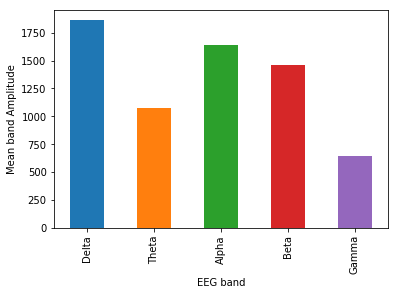

Opening raw data file /home/kovar/thesis_project/data/processed/73a.fif...
This filename (/home/kovar/thesis_project/data/processed/73a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 20358 =      0.000 ...    81.432 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/73a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


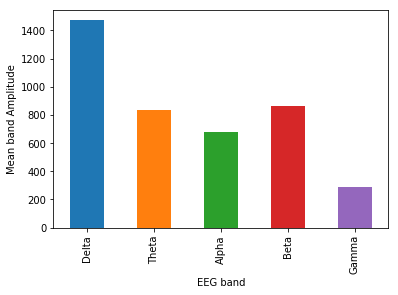

Opening raw data file /home/kovar/thesis_project/data/processed/1b.fif...
This filename (/home/kovar/thesis_project/data/processed/1b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 17421 =      0.000 ...    69.684 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/1b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


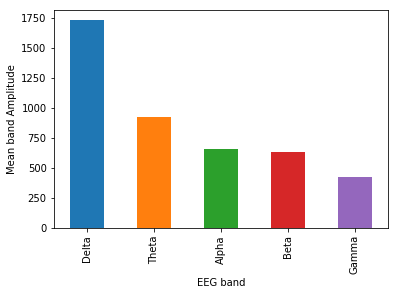

Opening raw data file /home/kovar/thesis_project/data/processed/16b.fif...
This filename (/home/kovar/thesis_project/data/processed/16b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 17506 =      0.000 ...    70.024 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/16b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


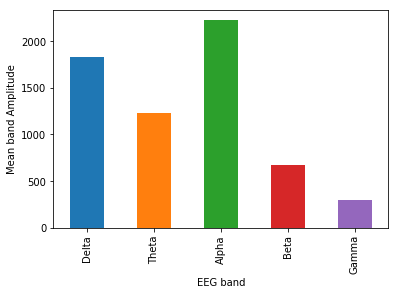

Opening raw data file /home/kovar/thesis_project/data/processed/105b.fif...
This filename (/home/kovar/thesis_project/data/processed/105b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 12493 =      0.000 ...    49.972 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/105b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


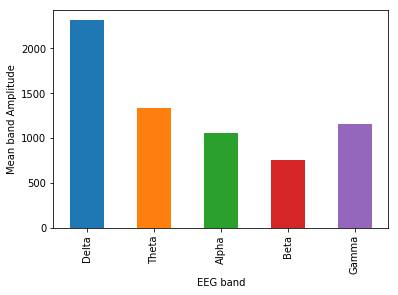

Opening raw data file /home/kovar/thesis_project/data/processed/102a.fif...
This filename (/home/kovar/thesis_project/data/processed/102a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/102a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


Isotrak not found
    Range : 0 ... 15541 =      0.000 ...    62.164 secs
Ready.


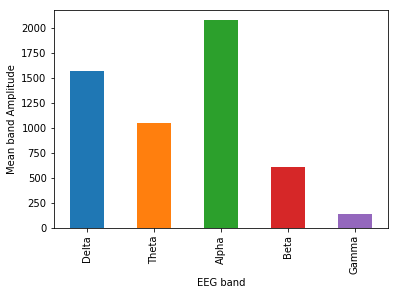

Opening raw data file /home/kovar/thesis_project/data/processed/70b.fif...
This filename (/home/kovar/thesis_project/data/processed/70b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 20594 =      0.000 ...    82.376 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/70b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


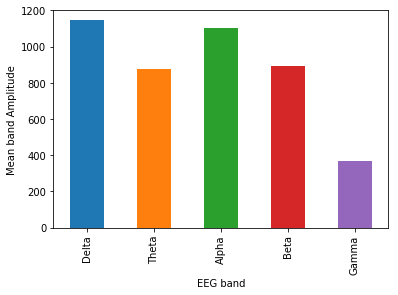

Opening raw data file /home/kovar/thesis_project/data/processed/67a.fif...
This filename (/home/kovar/thesis_project/data/processed/67a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16667 =      0.000 ...    66.668 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/67a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


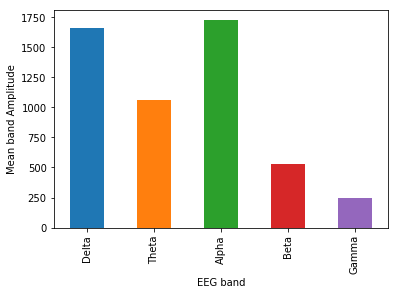

Opening raw data file /home/kovar/thesis_project/data/processed/19b.fif...
This filename (/home/kovar/thesis_project/data/processed/19b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 42710 =      0.000 ...   170.840 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/19b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


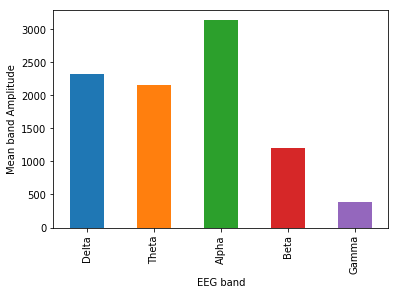

Opening raw data file /home/kovar/thesis_project/data/processed/111a.fif...
This filename (/home/kovar/thesis_project/data/processed/111a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 17275 =      0.000 ...    69.100 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/111a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


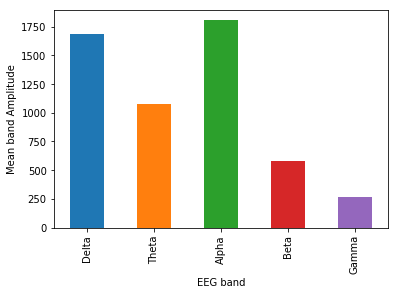

Opening raw data file /home/kovar/thesis_project/data/processed/33a.fif...
This filename (/home/kovar/thesis_project/data/processed/33a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15000 =      0.000 ...    60.000 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/33a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


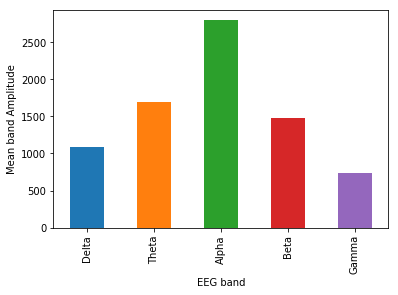

Opening raw data file /home/kovar/thesis_project/data/processed/129a.fif...
This filename (/home/kovar/thesis_project/data/processed/129a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 21740 =      0.000 ...    86.960 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/129a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


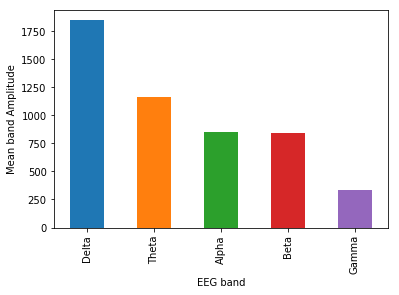

Opening raw data file /home/kovar/thesis_project/data/processed/106b.fif...
This filename (/home/kovar/thesis_project/data/processed/106b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 18572 =      0.000 ...    74.288 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/106b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


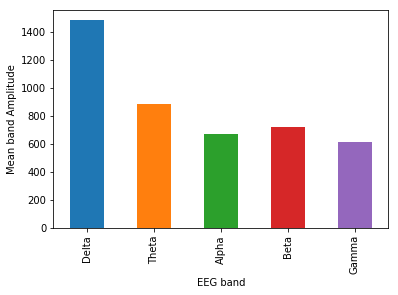

Opening raw data file /home/kovar/thesis_project/data/processed/89a.fif...
This filename (/home/kovar/thesis_project/data/processed/89a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 18703 =      0.000 ...    74.812 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/89a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


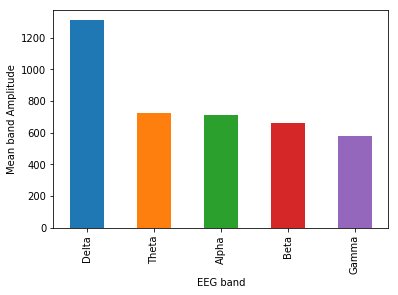

Opening raw data file /home/kovar/thesis_project/data/processed/83a.fif...
This filename (/home/kovar/thesis_project/data/processed/83a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15000 =      0.000 ...    60.000 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/83a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


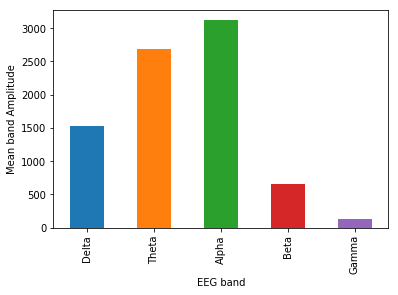

Opening raw data file /home/kovar/thesis_project/data/processed/39a.fif...
This filename (/home/kovar/thesis_project/data/processed/39a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15161 =      0.000 ...    60.644 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/39a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


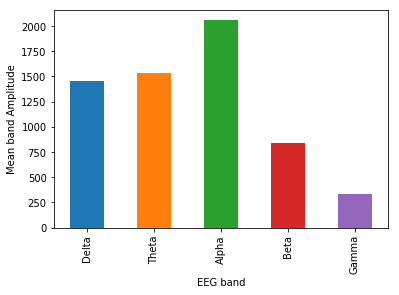

Opening raw data file /home/kovar/thesis_project/data/processed/12b.fif...
This filename (/home/kovar/thesis_project/data/processed/12b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 22053 =      0.000 ...    88.212 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/12b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


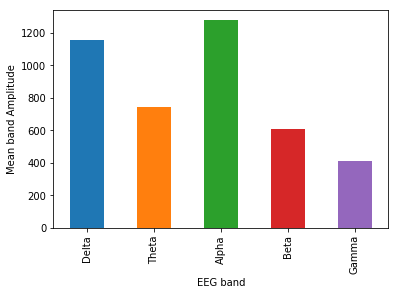

Opening raw data file /home/kovar/thesis_project/data/processed/102b.fif...
This filename (/home/kovar/thesis_project/data/processed/102b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 17019 =      0.000 ...    68.076 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/102b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


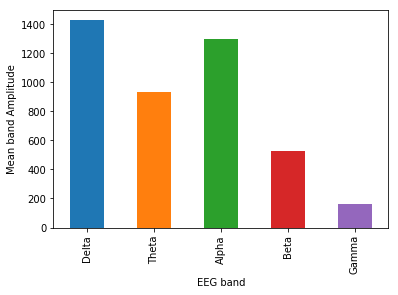

Opening raw data file /home/kovar/thesis_project/data/processed/36a.fif...
This filename (/home/kovar/thesis_project/data/processed/36a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 17254 =      0.000 ...    69.016 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/36a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


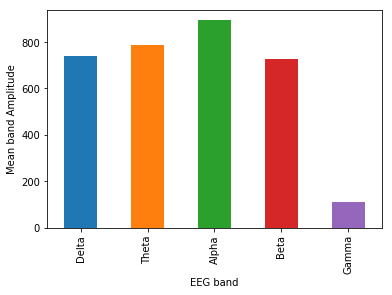

Opening raw data file /home/kovar/thesis_project/data/processed/94a.fif...
This filename (/home/kovar/thesis_project/data/processed/94a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 20162 =      0.000 ...    80.648 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/94a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


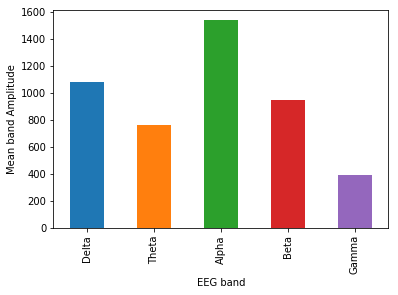

Opening raw data file /home/kovar/thesis_project/data/processed/87b.fif...
This filename (/home/kovar/thesis_project/data/processed/87b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 13043 =      0.000 ...    52.172 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/87b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


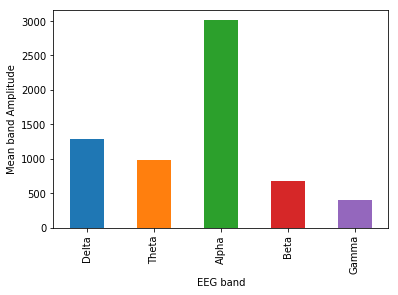

Opening raw data file /home/kovar/thesis_project/data/processed/63b.fif...
This filename (/home/kovar/thesis_project/data/processed/63b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 22252 =      0.000 ...    89.008 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/63b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


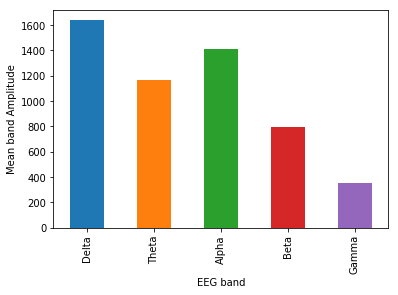

Opening raw data file /home/kovar/thesis_project/data/processed/69b.fif...
This filename (/home/kovar/thesis_project/data/processed/69b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 28704 =      0.000 ...   114.816 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/69b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


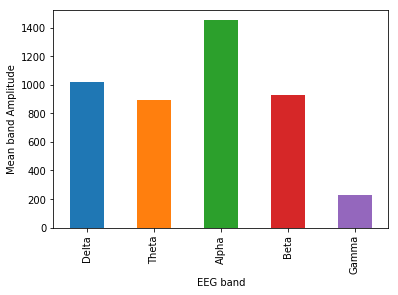

Opening raw data file /home/kovar/thesis_project/data/processed/59a.fif...
This filename (/home/kovar/thesis_project/data/processed/59a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19697 =      0.000 ...    78.788 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/59a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


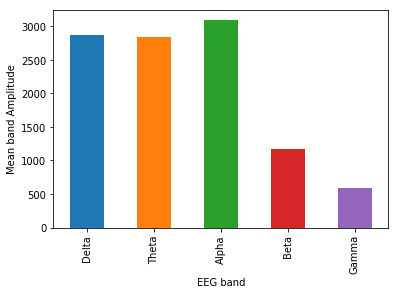

Opening raw data file /home/kovar/thesis_project/data/processed/32b.fif...
This filename (/home/kovar/thesis_project/data/processed/32b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 21400 =      0.000 ...    85.600 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/32b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


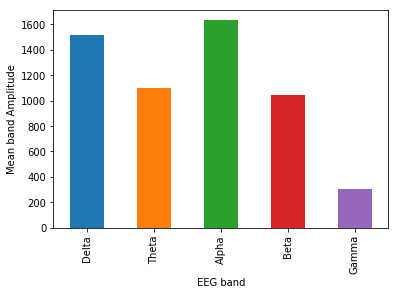

Opening raw data file /home/kovar/thesis_project/data/processed/84a.fif...
This filename (/home/kovar/thesis_project/data/processed/84a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 17061 =      0.000 ...    68.244 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/84a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


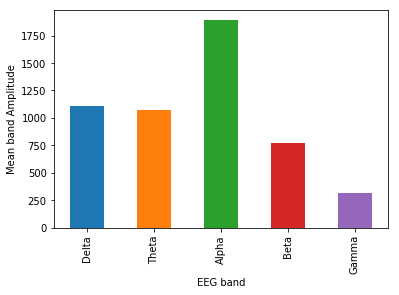

Opening raw data file /home/kovar/thesis_project/data/processed/111b.fif...
This filename (/home/kovar/thesis_project/data/processed/111b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 21389 =      0.000 ...    85.556 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/111b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


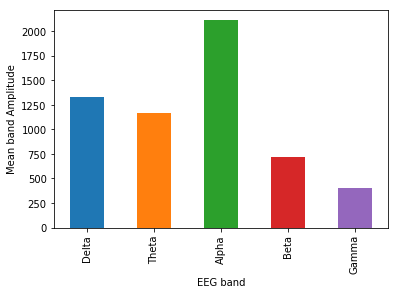

Opening raw data file /home/kovar/thesis_project/data/processed/7a.fif...
This filename (/home/kovar/thesis_project/data/processed/7a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15402 =      0.000 ...    61.608 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/7a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


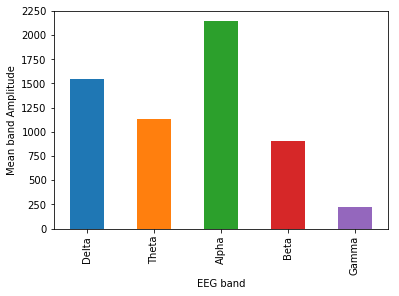

Opening raw data file /home/kovar/thesis_project/data/processed/125a.fif...
This filename (/home/kovar/thesis_project/data/processed/125a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15000 =      0.000 ...    60.000 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/125a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


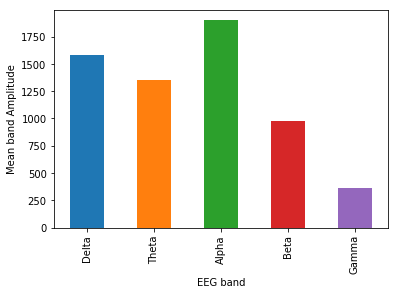

Opening raw data file /home/kovar/thesis_project/data/processed/97a.fif...
This filename (/home/kovar/thesis_project/data/processed/97a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15885 =      0.000 ...    63.540 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/97a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


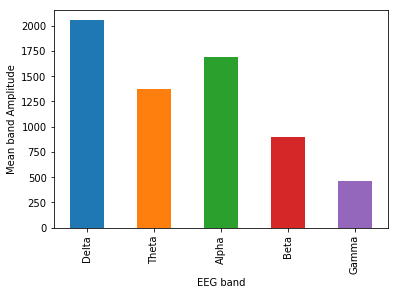

Opening raw data file /home/kovar/thesis_project/data/processed/79a.fif...
This filename (/home/kovar/thesis_project/data/processed/79a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15637 =      0.000 ...    62.548 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/79a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


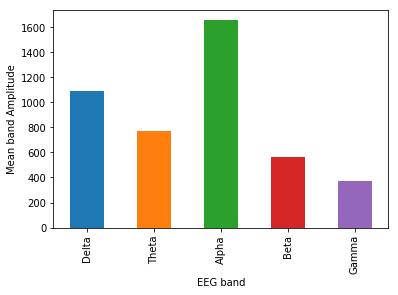

Opening raw data file /home/kovar/thesis_project/data/processed/69a.fif...
This filename (/home/kovar/thesis_project/data/processed/69a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16651 =      0.000 ...    66.604 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/69a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


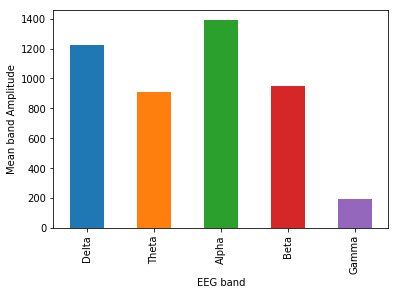

Opening raw data file /home/kovar/thesis_project/data/processed/9b.fif...
This filename (/home/kovar/thesis_project/data/processed/9b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15668 =      0.000 ...    62.672 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/9b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


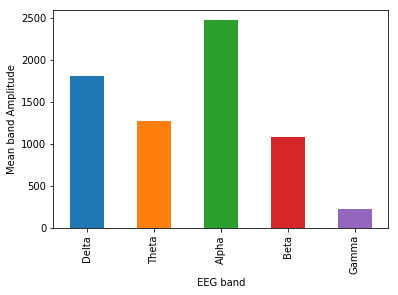

Opening raw data file /home/kovar/thesis_project/data/processed/72b.fif...
This filename (/home/kovar/thesis_project/data/processed/72b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 18362 =      0.000 ...    73.448 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/72b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


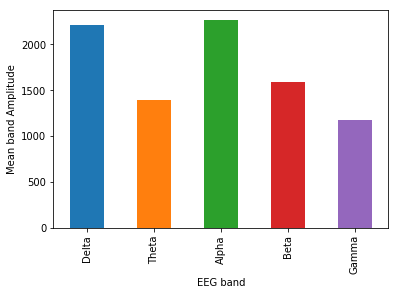

Opening raw data file /home/kovar/thesis_project/data/processed/131b.fif...
This filename (/home/kovar/thesis_project/data/processed/131b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15622 =      0.000 ...    62.488 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/131b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


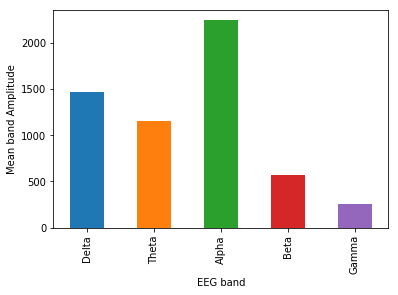

Opening raw data file /home/kovar/thesis_project/data/processed/82b.fif...
This filename (/home/kovar/thesis_project/data/processed/82b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 35099 =      0.000 ...   140.396 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/82b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


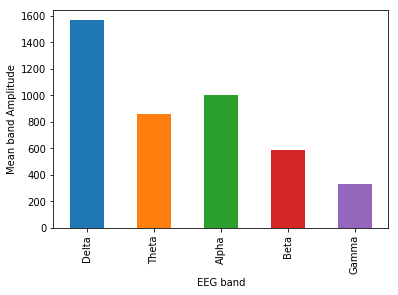

Opening raw data file /home/kovar/thesis_project/data/processed/130a.fif...
This filename (/home/kovar/thesis_project/data/processed/130a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 21131 =      0.000 ...    84.524 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/130a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


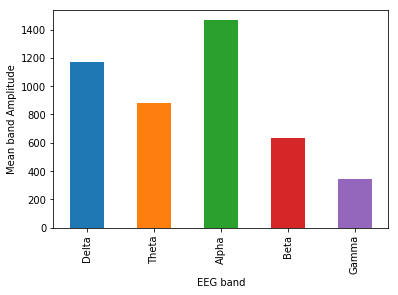

Opening raw data file /home/kovar/thesis_project/data/processed/112a.fif...
This filename (/home/kovar/thesis_project/data/processed/112a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 25135 =      0.000 ...   100.540 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/112a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


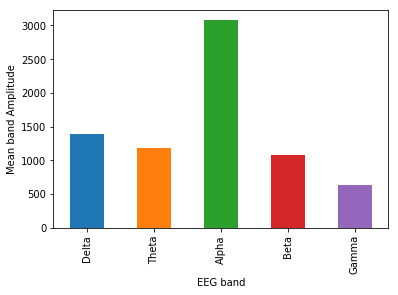

Opening raw data file /home/kovar/thesis_project/data/processed/122a.fif...
This filename (/home/kovar/thesis_project/data/processed/122a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 20348 =      0.000 ...    81.392 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/122a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


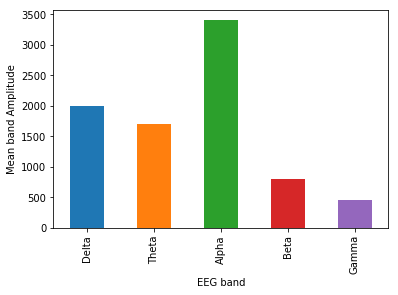

Opening raw data file /home/kovar/thesis_project/data/processed/40a.fif...
This filename (/home/kovar/thesis_project/data/processed/40a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 28206 =      0.000 ...   112.824 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/40a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


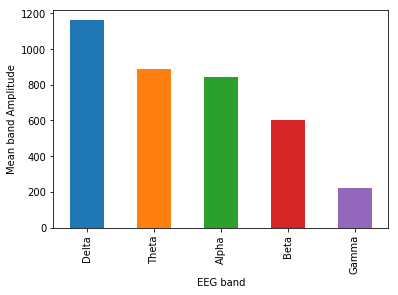

Opening raw data file /home/kovar/thesis_project/data/processed/101b.fif...
This filename (/home/kovar/thesis_project/data/processed/101b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 18015 =      0.000 ...    72.060 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/101b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


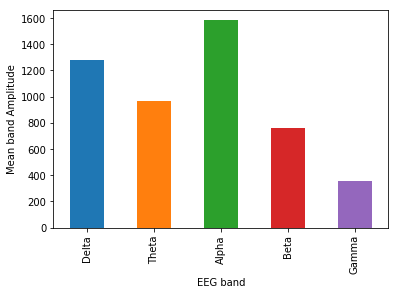

Opening raw data file /home/kovar/thesis_project/data/processed/87a.fif...
This filename (/home/kovar/thesis_project/data/processed/87a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15000 =      0.000 ...    60.000 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/87a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


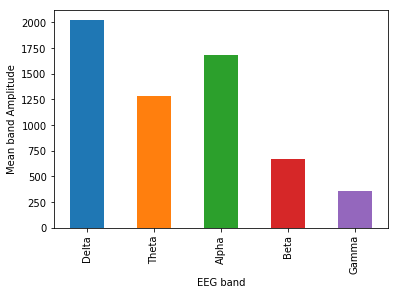

Opening raw data file /home/kovar/thesis_project/data/processed/95b.fif...
This filename (/home/kovar/thesis_project/data/processed/95b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15000 =      0.000 ...    60.000 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/95b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


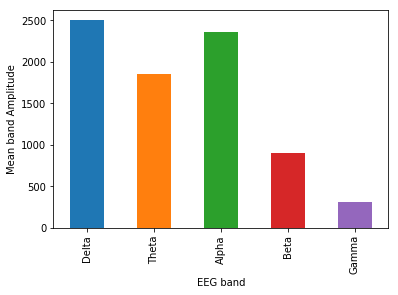

Opening raw data file /home/kovar/thesis_project/data/processed/118b.fif...
This filename (/home/kovar/thesis_project/data/processed/118b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 13024 =      0.000 ...    52.096 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/118b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


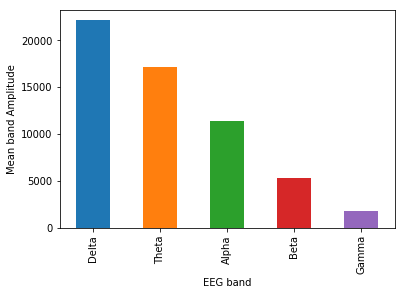

Opening raw data file /home/kovar/thesis_project/data/processed/97b.fif...
This filename (/home/kovar/thesis_project/data/processed/97b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 17296 =      0.000 ...    69.184 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/97b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


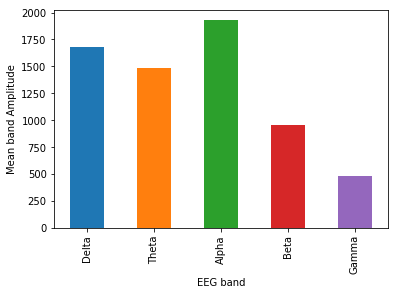

Opening raw data file /home/kovar/thesis_project/data/processed/20a.fif...
This filename (/home/kovar/thesis_project/data/processed/20a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16100 =      0.000 ...    64.400 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/20a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


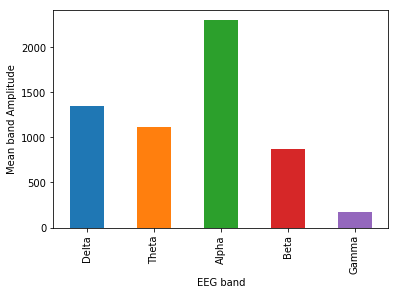

Opening raw data file /home/kovar/thesis_project/data/processed/132a.fif...
This filename (/home/kovar/thesis_project/data/processed/132a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 21804 =      0.000 ...    87.216 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/132a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


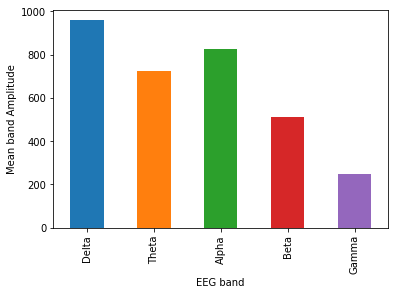

Opening raw data file /home/kovar/thesis_project/data/processed/92a.fif...
This filename (/home/kovar/thesis_project/data/processed/92a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16430 =      0.000 ...    65.720 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/92a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


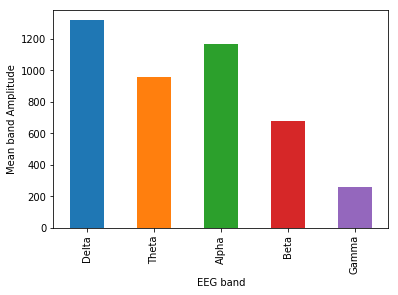

Opening raw data file /home/kovar/thesis_project/data/processed/81b.fif...
This filename (/home/kovar/thesis_project/data/processed/81b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 13127 =      0.000 ...    52.508 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/81b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


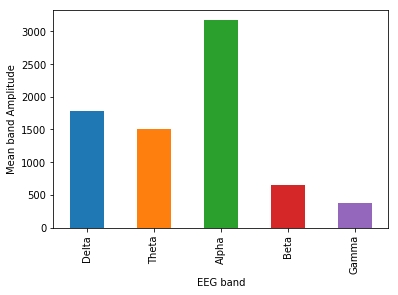

Opening raw data file /home/kovar/thesis_project/data/processed/46a.fif...
This filename (/home/kovar/thesis_project/data/processed/46a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 17443 =      0.000 ...    69.772 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/46a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


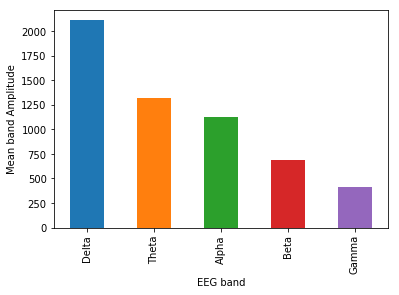

Opening raw data file /home/kovar/thesis_project/data/processed/88a.fif...
This filename (/home/kovar/thesis_project/data/processed/88a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 20087 =      0.000 ...    80.348 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/88a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


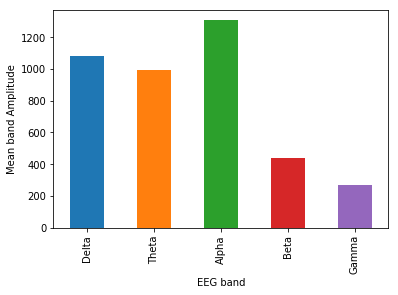

Opening raw data file /home/kovar/thesis_project/data/processed/133b.fif...
This filename (/home/kovar/thesis_project/data/processed/133b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16210 =      0.000 ...    64.840 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/133b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


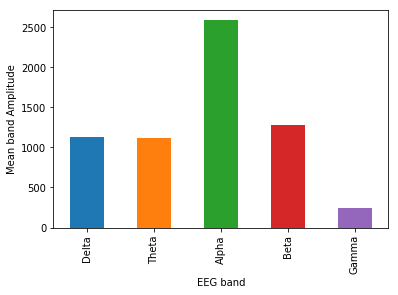

Opening raw data file /home/kovar/thesis_project/data/processed/17a.fif...
This filename (/home/kovar/thesis_project/data/processed/17a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16278 =      0.000 ...    65.112 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/17a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


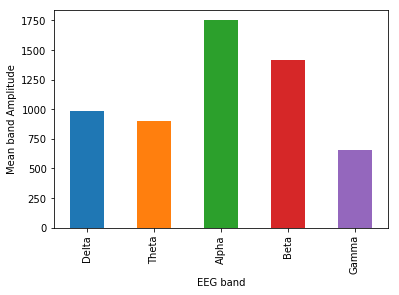

Opening raw data file /home/kovar/thesis_project/data/processed/50a.fif...
This filename (/home/kovar/thesis_project/data/processed/50a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16930 =      0.000 ...    67.720 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/50a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


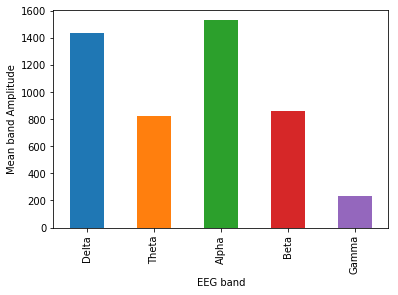

Opening raw data file /home/kovar/thesis_project/data/processed/110a.fif...
This filename (/home/kovar/thesis_project/data/processed/110a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 21165 =      0.000 ...    84.660 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/110a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


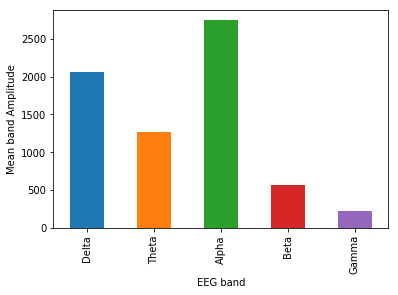

Opening raw data file /home/kovar/thesis_project/data/processed/27a.fif...
This filename (/home/kovar/thesis_project/data/processed/27a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15544 =      0.000 ...    62.176 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/27a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


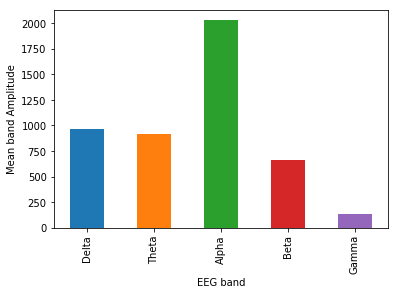

Opening raw data file /home/kovar/thesis_project/data/processed/57a.fif...
This filename (/home/kovar/thesis_project/data/processed/57a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15000 =      0.000 ...    60.000 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/57a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


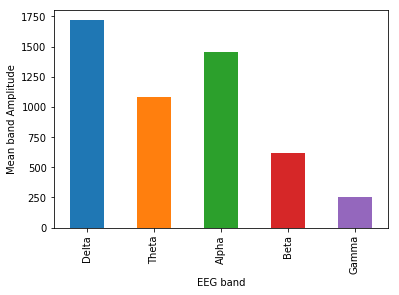

Opening raw data file /home/kovar/thesis_project/data/processed/75b.fif...
This filename (/home/kovar/thesis_project/data/processed/75b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 35665 =      0.000 ...   142.660 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/75b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


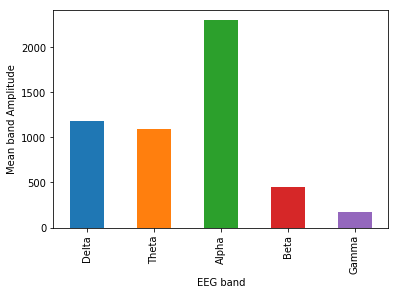

Opening raw data file /home/kovar/thesis_project/data/processed/26a.fif...
This filename (/home/kovar/thesis_project/data/processed/26a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 18679 =      0.000 ...    74.716 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/26a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


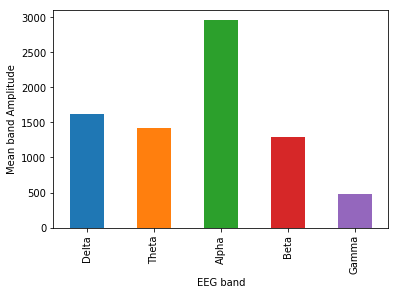

Opening raw data file /home/kovar/thesis_project/data/processed/45b.fif...
This filename (/home/kovar/thesis_project/data/processed/45b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 13759 =      0.000 ...    55.036 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/45b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


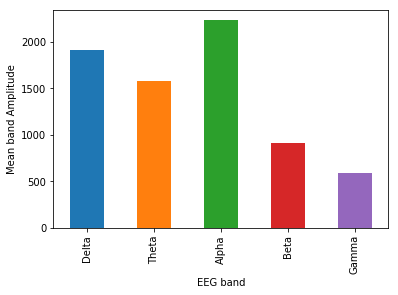

Opening raw data file /home/kovar/thesis_project/data/processed/74b.fif...
This filename (/home/kovar/thesis_project/data/processed/74b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15805 =      0.000 ...    63.220 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/74b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


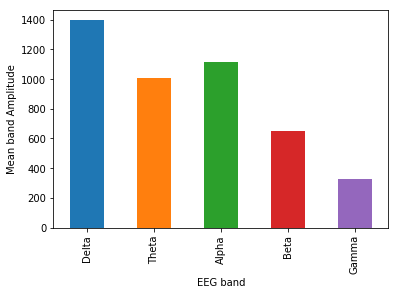

Opening raw data file /home/kovar/thesis_project/data/processed/104a.fif...
This filename (/home/kovar/thesis_project/data/processed/104a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 20761 =      0.000 ...    83.044 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/104a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


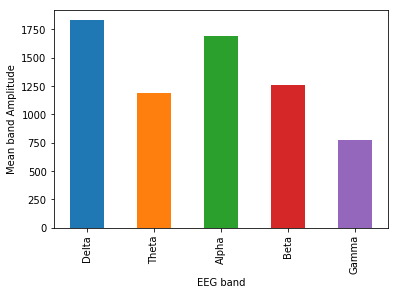

Opening raw data file /home/kovar/thesis_project/data/processed/4b.fif...
This filename (/home/kovar/thesis_project/data/processed/4b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 25508 =      0.000 ...   102.032 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/4b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


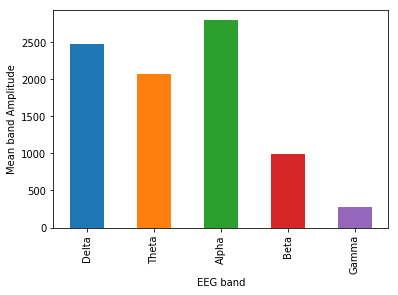

Opening raw data file /home/kovar/thesis_project/data/processed/29a.fif...
This filename (/home/kovar/thesis_project/data/processed/29a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 21296 =      0.000 ...    85.184 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/29a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


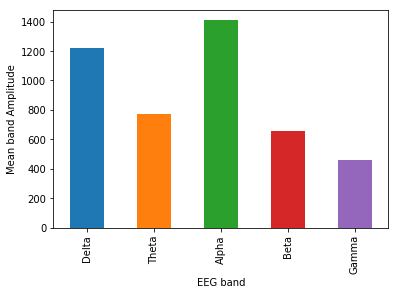

Opening raw data file /home/kovar/thesis_project/data/processed/130b.fif...
This filename (/home/kovar/thesis_project/data/processed/130b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 29189 =      0.000 ...   116.756 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/130b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


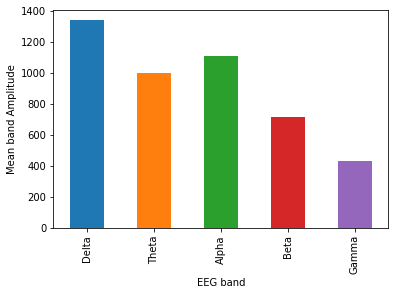

Opening raw data file /home/kovar/thesis_project/data/processed/49b.fif...
This filename (/home/kovar/thesis_project/data/processed/49b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 21506 =      0.000 ...    86.024 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/49b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


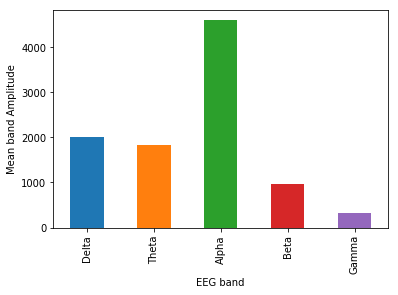

Opening raw data file /home/kovar/thesis_project/data/processed/125b.fif...
This filename (/home/kovar/thesis_project/data/processed/125b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 7655 =      0.000 ...    30.620 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/125b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


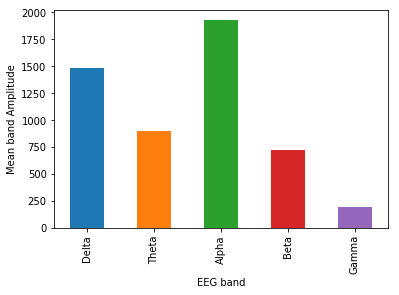

Opening raw data file /home/kovar/thesis_project/data/processed/31b.fif...
This filename (/home/kovar/thesis_project/data/processed/31b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 21892 =      0.000 ...    87.568 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/31b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


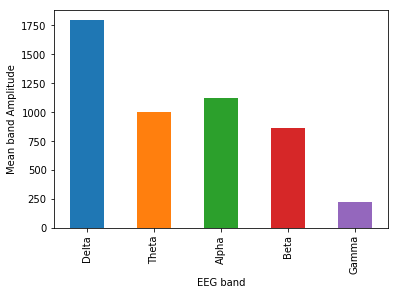

Opening raw data file /home/kovar/thesis_project/data/processed/46b.fif...
This filename (/home/kovar/thesis_project/data/processed/46b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 21897 =      0.000 ...    87.588 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/46b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


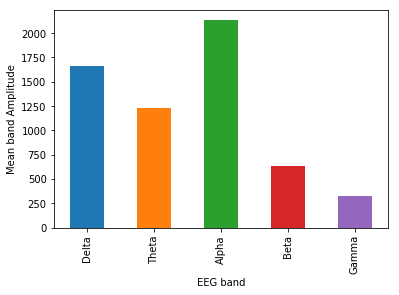

Opening raw data file /home/kovar/thesis_project/data/processed/114a.fif...
This filename (/home/kovar/thesis_project/data/processed/114a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15831 =      0.000 ...    63.324 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/114a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


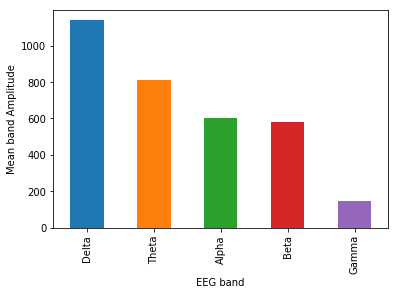

Opening raw data file /home/kovar/thesis_project/data/processed/119b.fif...
This filename (/home/kovar/thesis_project/data/processed/119b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 15000 =      0.000 ...    60.000 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/119b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


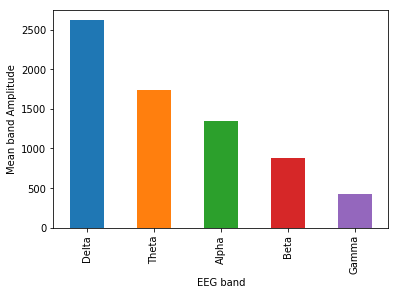

Opening raw data file /home/kovar/thesis_project/data/processed/40b.fif...
This filename (/home/kovar/thesis_project/data/processed/40b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 10044 =      0.000 ...    40.176 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/40b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


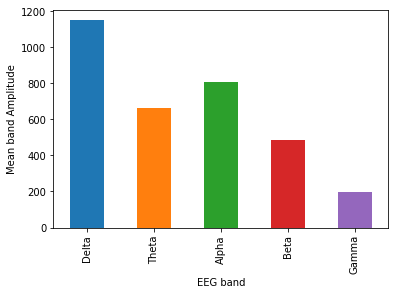

Opening raw data file /home/kovar/thesis_project/data/processed/93a.fif...
This filename (/home/kovar/thesis_project/data/processed/93a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 13452 =      0.000 ...    53.808 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/93a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


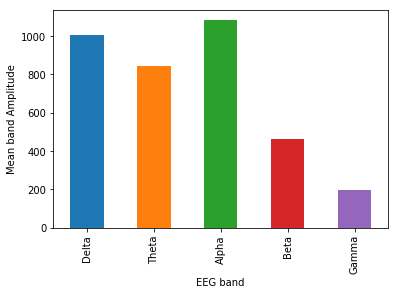

Opening raw data file /home/kovar/thesis_project/data/processed/30a.fif...
This filename (/home/kovar/thesis_project/data/processed/30a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 23295 =      0.000 ...    93.180 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/30a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


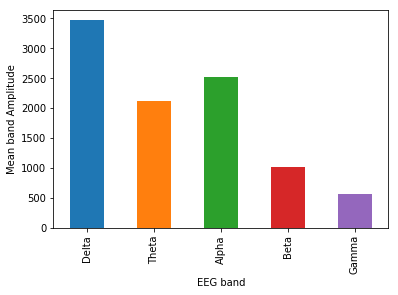

Opening raw data file /home/kovar/thesis_project/data/processed/82a.fif...
This filename (/home/kovar/thesis_project/data/processed/82a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 27593 =      0.000 ...   110.372 secs
Ready.


/home/kovar/thesis_project/src/data/data_files.py:25: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/82a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(file_path)


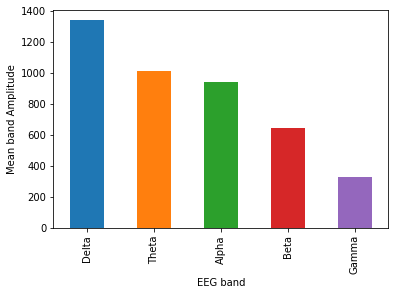

In [23]:
from data.data_files import CHANNEL_NAMES, DataKind, files_builder
def bar_bands(x):
    fs = 256                                # Sampling rate (512 Hz)

    # Get real amplitudes of FFT (only in postive frequencies)
    fft_vals = np.absolute(np.fft.rfft(x))

    # Get frequencies for amplitudes in Hz
    fft_freq = np.fft.rfftfreq(len(x), 1.0/fs)

    # Define EEG bands
    eeg_bands = {'Delta': (0, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 30),
                 'Gamma': (30, 45)}

    # Take the mean of the fft amplitude for each EEG band
    eeg_band_fft = dict()
    for band in eeg_bands:  
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                           (fft_freq <= eeg_bands[band][1]))[0]
        eeg_band_fft[band] = np.mean(fft_vals[freq_ix])

    # Plot the x (using pandas here cause it's easy)
    import pandas as pd
    df = pd.DataFrame(columns=['band', 'val'])
    df['band'] = eeg_bands.keys()
    df['val'] = [eeg_band_fft[band] for band in eeg_bands]
    ax = df.plot.bar(x='band', y='val', legend=False)
    ax.set_xlabel("EEG band")
    ax.set_ylabel("Mean band Amplitude")
    plt.show()

for file in files_builder(DataKind('processed')):
    bar_bands(file.df['FP1'][:15000])